<a href="https://colab.research.google.com/github/AggyP/Background-study/blob/main/NT_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import SilhouetteVisualizer
#from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import preprocessing
from matplotlib import style
from statistics import mean
from scipy.stats import ttest_1samp
from scipy.stats.stats import pearsonr

In [ ]:
from google.colab import auth
auth.authenticate_user()

#Obtain Data from bigquery

In [ ]:
%%bigquery --project zeta-pivot-318307 --use_legacy_sql --verbose df_ambient
SELECT 
  DeviceID,Datetime,AmbientTemp,CO2,AmbientHumid,AmbientPressure
FROM [AG_TEST.ambient]

In [ ]:
%%bigquery --project plexiform-muse-353212 --use_legacy_sql --verbose df_ambient
SELECT 
  DeviceID,Datetime,AmbientTemp,CO2,AmbientHumid,AmbientPressure
FROM [NTsensor.ambientnew]

Executing query with job ID: b8403024-28d6-4b75-a2e2-175fe7f80bee
Query executing: 1.90s
Query complete after 2.40s


In [ ]:
%%bigquery --project plexiform-muse-353212 --use_legacy_sql --verbose df_light
SELECT 
  DeviceID,Datetime,LightIntensity
FROM [NTsensor.lightnew]

Executing query with job ID: 4384332e-578a-4b84-a5bb-aa7deeef9427
Query executing: 1.96s
Query complete after 2.37s


In [ ]:
%%bigquery --project plexiform-muse-353212 --use_legacy_sql --verbose df_soil
SELECT 
  DeviceID,Datetime,SoilEC,SoilMoisture,SoilTemp
FROM [NTsensor.soil]

Executing query with job ID: 7d12898c-ad2b-4cc5-a777-a4ddada64fba
Query executing: 1.68s
Query complete after 2.05s


In [ ]:
#copy the imported dataframe into new dataframe
dfambient = df_ambient.copy()
dfsoil = df_soil.copy()
dflight = df_light.copy()

In [ ]:
dfsoil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252875 entries, 0 to 252877
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DeviceID      252875 non-null  object        
 1   Datetime      252875 non-null  datetime64[ns]
 2   SoilEC        252875 non-null  float64       
 3   SoilMoisture  252875 non-null  float64       
 4   SoilTemp      252875 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 11.6+ MB


#Pre-processing


In [ ]:
#drop duplicates
dfsoil = dfsoil.drop_duplicates()
dflight = dflight.drop_duplicates()
dfambient = dfambient.drop_duplicates()

In [ ]:
#function to truncate time to minute only
def truncatetominute(df):
    df['Datetime']=df['Datetime'].map(lambda x:x.strftime('%Y-%m-%d %H:%M'))

In [ ]:
#function to extract hour from datetime
def extracthour(df):
  df['Datetime'] = pd.to_datetime(df['Datetime'])
  df['hour']=df['Datetime'].dt.hour

In [ ]:
#function to drop column
def dropcolumn(df,columnlist):
  df.drop(columnlist,axis=1,inplace=True) #axis 1 refers to the columns #inplace=true save the new output to the existing DataFrame

In [ ]:
#function to check missing values
def checkmissing(df):
  print(round((df.isnull().sum()/len(df)*100),2).sort_values(ascending=False))

In [ ]:
#function to rename columns
def rename(df,oldname,newname):
  df.rename(columns={oldname:newname},inplace=True)

In [ ]:
#descritize numeric column into bins
def descritize(df,column,bins):
  df['rank']=pd.cut(df[column],bins)
  print(df.groupby('rank')[column].count())

In [ ]:
#rename column
rename(dfsoil,'SoilMoisture','SubstrateMoisture')
rename(dfsoil,'SoilEC','SubstrateEC')
rename(dfsoil,'SoilTemp','SubstrateTemp')

In [ ]:
#truncate datetime for each element)
truncatetominute(dfambient)
truncatetominute(dfsoil)
truncatetominute(dflight)

In [ ]:
#Display only rows with at least 1 missing value
dfsoil[dfsoil.isnull().any(axis=1)] #axis 1 refers to the columns #any tells it to display any rows consisting of at least 1 missing value

,DeviceID,Datetime,SubstrateEC,SubstrateMoisture,SubstrateTemp


In [ ]:
#Create a dataframe with only sensor in warehouse
dfambientRT = dfambient.loc[(dfambient["DeviceID"] == "24E124126B026059") | (dfambient["DeviceID"] == "24E124126B025731") | (dfambient["DeviceID"] =="24E124126B023877") | (dfambient["DeviceID"] =="24E124126B025964")|(dfambient["DeviceID"] =="24E124126B025778")]


In [ ]:
#Create a dataframe with only sensor in insectary
dfambientAL = dfambient.loc[(dfambient["DeviceID"] != "24E124126B026059") & (dfambient["DeviceID"] != "24E124126B025731") & (dfambient["DeviceID"] !="24E124126B023877") & (dfambient["DeviceID"] !="24E124126B025964")&(dfambient["DeviceID"] !="24E124126B025778")]


###Merge two dataframe

In [ ]:
#merge ambient and light data insectary
df_combinedAL = pd.merge(dfambientAL,dflight, left_on='Datetime', right_on='Datetime', how='left')

In [ ]:
#merge ambient and light data insectary
df_combinedAL = pd.merge(dfambientAL,dflight, left_on='Datetime', right_on='Datetime', how='inner')

In [ ]:
#merge ambient and soil data warehouse
df_combinedRT = pd.merge(dfambientRT,dfsoil,left_on='Datetime', right_on='Datetime', how='left')

In [ ]:
#check all rows with null
df_combinedAL[df_combinedAL.isnull().any(axis=1)]

,DeviceID_x,Datetime,AmbientTemp,CO2,AmbientHumid,AmbientPressure,DeviceID_y,LightIntensity


In [ ]:
 #df_combinedAL['LightIntensity'].interpolate(inplace=True)

In [ ]:
checkmissing(df_combinedAL)

DeviceID_x         0.0
Datetime           0.0
AmbientTemp        0.0
CO2                0.0
AmbientHumid       0.0
AmbientPressure    0.0
DeviceID_y         0.0
LightIntensity     0.0
dtype: float64


### Drop irrelavant rows,columns

In [ ]:
#drop NA
df_combinedAL.dropna(inplace=True)
df_combinedRT.dropna(inplace=True)

In [ ]:
#drop columns
dropcolumn(df_combinedAL,['DeviceID_x','DeviceID_y'])
dropcolumn(df_combinedRT,['DeviceID_x','DeviceID_y'])

### Hour range

In [ ]:
extracthour(df_combinedAL)

In [ ]:
checkmissing(df_combinedAL)

DeviceID_x         0.0
Datetime           0.0
AmbientTemp        0.0
CO2                0.0
AmbientHumid       0.0
AmbientPressure    0.0
DeviceID_y         0.0
LightIntensity     0.0
hour               0.0
dtype: float64


In [ ]:
#extract certain range of hour into new dataframe
#5 to 11
dfmorning = df_combinedAL.loc[(df_combinedAL["hour"] >=5)&(df_combinedAL["hour"] <=11)]
#12 to 17
dfafternoon = df_combinedAL.loc[(df_combinedAL["hour"] >=12)&(df_combinedAL["hour"] <=17)]
#18 to 23
dfevening = df_combinedAL.loc[(df_combinedAL["hour"] >=18)&(df_combinedAL["hour"] <=23)]
#1 to 4
dfmidnight = df_combinedAL.loc[(df_combinedAL["hour"] >=0)&(df_combinedAL["hour"] <=4)]

In [ ]:
#Discretize with label
bins = [0,7,11,19,23]
labels=['12a.m.-7a.m','8a.m.-11a.m.','12p.m.-6p.m.','7p.m.-11p.m.']
df_combinedAL['rank_hour']=pd.cut(df_combinedAL['hour'], bins=bins,include_lowest=True,labels=labels)

In [ ]:
df_test = df_combinedAL.loc[(df_combinedAL['LightIntensity'] == 0)]
df_test.groupby(['DeviceID_y', 'rank_hour']).size().unstack()

rank_hour,12a.m.-7a.m,8a.m.-11a.m.,12p.m.-6p.m.,7p.m.-11p.m.
DeviceID_y,,,,
24E124126B260954,2833,0,359,1624
24E124126B261002,8101,0,959,4445
24E124126B261090,1153,0,96,650
24E124126B261286,3489,0,438,2022
24E124126B263783,2301,6,214,1266
24E124126B263804,1897,0,230,1059
24E124126B264083,2551,0,360,1425
24E124126B264441,2839,0,311,1631
24E124126B265398,3204,0,438,1867


In [ ]:
#check zero values in ambient temperature
df_test = df_combinedAL.loc[(df_combinedAL['AmbientTemp'] == 0)]
df_test.groupby(['DeviceID_x', 'rank_hour']).size().unstack()

rank_hour,12a.m.-7a.m,8a.m.-11a.m.,12p.m.-6p.m.,7p.m.-11p.m.
DeviceID_x,,,,
24E124126B023974,0,0,0,8
24E124126B024007,4,3,17,9
24E124126B025873,0,0,0,3
24E124126B026003,7,0,7,10
24E124126B026484,0,0,0,2
24E124126B027438,0,0,0,3
24E124126B028164,47,1,0,14
24E124126B028174,25,3,31,25


In [ ]:
#function to check mean,mode,median of different hour range
def checkmean(df,column1,lower,upper,column2):
  mean=df[(df[column1]>=lower)&(df[column1]<=upper)][column2].mean()
  print(mean)

def checkmode(df,column1,lower,upper,column2):
  mode=df[(df[column1]>=lower)&(df[column1]<=upper)][column2].mode()[0]
  print(mode)

def checkmedian(df,column1,lower,upper,column2):
  median=df[(df[column1]>=lower)&(df[column1]<=upper)][column2].median()
  print(median)

In [ ]:
checkmean(df_combinedAL,'hour',5,11,'LightIntensity')

1009.7014328314787


In [ ]:
checkmode(df_combinedAL,'hour',5,11,'LightIntensity')
checkmedian(df_combinedAL,'hour',5,11,'LightIntensity')

0.0
450.0


In [ ]:
checkmedian(df_combinedAL,'hour',8,11,'AmbientTemp')
checkmedian(df_combinedAL,'hour',12,17,'AmbientTemp')
checkmedian(df_combinedAL,'hour',18,23,'AmbientTemp')
checkmedian(df_combinedAL,'hour',0,7,'AmbientTemp')

29.4
32.9
27.5
25.7


In [ ]:
checkmean(df_combinedAL,'hour',8,11,'LightIntensity')
checkmean(df_combinedAL,'hour',12,17,'LightIntensity')
checkmean(df_combinedAL,'hour',18,23,'LightIntensity')
checkmean(df_combinedAL,'hour',0,7,'LightIntensity')

1737.7824588280353
1966.97742634868
40.1263545458349
16.74738841405508


In [ ]:
checkmode(df_combinedAL,'hour',8,11,'LightIntensity')
checkmode(df_combinedAL,'hour',12,17,'LightIntensity')
checkmode(df_combinedAL,'hour',18,23,'LightIntensity')
checkmode(df_combinedAL,'hour',0,7,'LightIntensity')

260.0
830.0
0.0
0.0


In [ ]:
meanmorning=df_combinedAL[(df_combinedAL['hour']>=8)&(df_combinedAL['hour']<=11)]['LightIntensity'].mean()
meanafternoon= df_combinedAL[(df_combinedAL['hour']>=12)&(df_combinedAL['hour']<=17)]['LightIntensity'].mean()
meanevening = df_combinedAL[(df_combinedAL['hour']>=18)&(df_combinedAL['hour']<=23)]['LightIntensity'].mean()
meanmidnight = df_combinedAL[(df_combinedAL['hour']>=0)&(df_combinedAL['hour']<=7)]['LightIntensity'].mean()

In [ ]:
meanmorningtemp=df_combinedAL[(df_combinedAL['hour']>=8)&(df_combinedAL['hour']<=11)]['AmbientTemp'].mean()
meanafternoontemp= df_combinedAL[(df_combinedAL['hour']>=12)&(df_combinedAL['hour']<=17)]['AmbientTemp'].mean()
meaneveningtemp = df_combinedAL[(df_combinedAL['hour']>=18)&(df_combinedAL['hour']<=23)]['AmbientTemp'].mean()
meanmidnighttemp = df_combinedAL[(df_combinedAL['hour']>=0)&(df_combinedAL['hour']<=7)]['AmbientTemp'].mean()

In [ ]:
print(meanmidnight)
print(meanmorning)
print(meanafternoon)
print(meanevening)

16.725917974299875
1737.7024181713775
1967.092352092352
40.04793464215748


In [ ]:
print(meanmidnighttemp)
print(meanmorningtemp)
print(meanafternoontemp)
print(meaneveningtemp)

25.670477398153274
29.39841264166458
32.352543222848404
27.59483545861033


In [ ]:
df_combinedAL[(df_combinedAL['hour']>=18)&(df_combinedAL['hour']<=23)]['LightIntensity'].describe()

count    23901.000000
mean        40.126355
std        132.449377
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2960.000000
Name: LightIntensity, dtype: float64

In [ ]:
df_combinedAL.describe()

,AmbientTemp,CO2,AmbientHumid,AmbientPressure,LightIntensity,hour
count,94899.000000,94899.000000,94899.000000,94899.00000,94899.000000,94899.000000
mean,28.632629,386.046997,79.551934,1007.44131,807.110830,11.517097
std,3.467730,59.225893,14.315934,32.78633,1406.568342,6.939213
min,22.200000,0.000000,0.000000,0.00000,10.000000,0.000000
25%,25.900000,357.000000,69.500000,1007.10000,16.725918,5.000000
50%,27.400000,387.000000,84.000000,1008.60000,40.047935,12.000000
75%,31.100000,420.000000,90.500000,1010.00000,1110.000000,18.000000
max,41.100000,631.000000,100.000000,1016.20000,15210.000000,23.000000


In [ ]:
#Checking the mean
# mean_morning=df_combinedAL[(df_combinedAL['hour']>=5) & (df_combinedAL["hour"] <=11)]['LightIntensity'].mean()
# mean_afternoon=df_combinedAL[(df_combinedAL['hour']>=12) & (df_combinedAL["hour"] <=17)]['LightIntensity'].mean()
# mean_evening=df_combinedAL[(df_combinedAL['hour']>=18) & (df_combinedAL["hour"] <=23)]['LightIntensity'].mean()
# mean_midnight=df_combinedAL[(df_combinedAL['hour']>=0) & (df_combinedAL["hour"] <=4)]['LightIntensity'].mean()
# print(mean_morning)
# print(mean_afternoon)
# print(mean_evening)
# print(mean_midnight)

In [ ]:
#checking the mode
# mode_morning=df_combinedAL[(df_combinedAL['hour']>=5) & (df_combinedAL["hour"] <=11)]['LightIntensity'].mode()[0]
# mode_afternoon=df_combinedAL[(df_combinedAL['hour']>=12) & (df_combinedAL["hour"] <=17)]['LightIntensity'].mode()[0]
# mode_evening=df_combinedAL[(df_combinedAL['hour']>=18) & (df_combinedAL["hour"] <=23)]['LightIntensity'].mode()[0]
# mode_midnight=df_combinedAL[(df_combinedAL['hour']>=0) & (df_combinedAL["hour"] <=4)]['LightIntensity'].mode()[0]
# print(mode_morning)
# print(mode_afternoon)
# print(mode_evening)
# print(mode_midnight)

In [ ]:
# median_morning=df_combinedAL[(df_combinedAL['hour']>=5) & (df_combinedAL["hour"] <=11)]['LightIntensity'].median()
# median_afternoon=df_combinedAL[(df_combinedAL['hour']>=12) & (df_combinedAL["hour"] <=17)]['LightIntensity'].median()
# median_evening=df_combinedAL[(df_combinedAL['hour']>=18) & (df_combinedAL["hour"] <=23)]['LightIntensity'].median()
# median_midnight=df_combinedAL[(df_combinedAL['hour']>=0) & (df_combinedAL["hour"] <=4)]['LightIntensity'].median()
# print(median_morning)
# print(median_afternoon)
# print(median_evening)
# print(median_midnight)

###Impute value

In [ ]:
mean=df_combinedAL[(df_combinedAL['hour']>=8)&(df_combinedAL['hour']<=11)]['AmbientTemp'].mean()

In [ ]:
#replace zero to mean
dfmorning['LightIntensity'] = dfmorning['LightIntensity'].replace(0,mean_morning)

In [ ]:
df_combinedAL.loc[(df_combinedAL['LightIntensity']==0.00)]

,DeviceID_x,Datetime,AmbientTemp,CO2,AmbientHumid,AmbientPressure,DeviceID_y,LightIntensity,hour


In [ ]:
df_combinedAL.loc[(df_combinedAL['hour'] >8) & (df_combinedAL["hour"] <=11) & (df_combinedAL['LightIntensity']== 0),'LightIntensity'] = meanmorning
df_combinedAL.loc[(df_combinedAL['hour'] >=0) & (df_combinedAL["hour"] <=7) & (df_combinedAL['LightIntensity']== 0),'LightIntensity'] = meanmidnight
df_combinedAL.loc[(df_combinedAL['hour'] >=12) & (df_combinedAL["hour"] <=18)& (df_combinedAL['LightIntensity']== 0),'LightIntensity']=meanafternoon
df_combinedAL.loc[(df_combinedAL['hour'] >=19) & (df_combinedAL["hour"] <=23)& (df_combinedAL['LightIntensity']== 0),'LightIntensity']=meanevening

In [ ]:
#replace zero values ambient temperature to the mean for the specific hour
df_combinedAL.loc[(df_combinedAL['hour'] >=0) & (df_combinedAL["hour"] <=7) & (df_combinedAL['AmbientTemp']== 0),'AmbientTemp'] = meanmidnighttemp
df_combinedAL.loc[(df_combinedAL['hour'] >=8) & (df_combinedAL["hour"] <=11)& (df_combinedAL['AmbientTemp']== 0),'AmbientTemp'] = meanmorningtemp
df_combinedAL.loc[(df_combinedAL['hour'] >=12) & (df_combinedAL["hour"] <=18)& (df_combinedAL['AmbientTemp']== 0),'AmbientTemp']=meanafternoontemp
df_combinedAL.loc[(df_combinedAL['hour'] >=19) & (df_combinedAL["hour"] <=23)& (df_combinedAL['AmbientTemp']== 0),'AmbientTemp']=meaneveningtemp

In [ ]:
df_combinedAL.describe()

,AmbientTemp,CO2,AmbientHumid,AmbientPressure,LightIntensity,hour
count,94899.000000,94899.000000,94899.000000,94899.00000,94899.000000,94899.000000
mean,28.632629,386.046997,79.551934,1007.44131,791.095691,11.517097
std,3.467730,59.225893,14.315934,32.78633,1413.494389,6.939213
min,22.200000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,25.900000,357.000000,69.500000,1007.10000,0.000000,5.000000
50%,27.400000,387.000000,84.000000,1008.60000,0.000000,12.000000
75%,31.100000,420.000000,90.500000,1010.00000,1100.000000,18.000000
max,41.100000,631.000000,100.000000,1016.20000,15210.000000,23.000000


In [ ]:
#df_combinedAL['LightIntensity'] = df_combinedAL['LightIntensity'].map( lambda x : mean if x == 0 else x)

#Distribution

###Histogram

In [ ]:
#Histogram for insectary (AL)
plt.figure(figsize=(16,14))

#Histogram for loanAmount
plt.subplot(3,3,1)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B024007']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,5000])
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B024007')

#Histogram for nPaidOff
plt.subplot(3,3,2)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025873']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,21])
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B025873')

plt.subplot(3,3,3)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B023974']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B023974')

plt.subplot(3,3,4)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B026003']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B026003')

plt.subplot(3,3,5)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B024007']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B024007')

plt.subplot(3,3,6)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B028164']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B028164')

plt.subplot(3,3,7)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B028174']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B028174')

plt.subplot(3,3,8)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B027438']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B027438')

plt.subplot(3,3,9)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B026484']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B026484')

In [ ]:
#Histogram for warehouse (RT)
plt.figure(figsize=(14,10))

#Histogram for loanAmount
plt.subplot(2, 3, 1)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B026059']['AmbientHumid'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,5000])
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientHumid-24E124126B026059')

#Histogram for nPaidOff
plt.subplot(2, 3, 2)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025731']['AmbientHumid'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,21])
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientHumid-24E124126B025731')

plt.subplot(2,3,3)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B023877']['AmbientHumid'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientHumid-24E124126B023877')

plt.subplot(2,3,4)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025964']['AmbientHumid'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientHumid-24E124126B025964')

plt.subplot(2,3,5)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025778']['AmbientHumid'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientHumid-24E124126B025778')

###Density plot

In [ ]:
x = df_combinedAL['AmbientTemp'].values
y = df_combinedAL['AmbientHumid'].values

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
scaledtemp = min_max_scaler.fit_transform(x.reshape(-1,1))
scaledhumid = min_max_scaler.fit_transform(y.reshape(-1,1))

In [ ]:
scaledlight = (df_combinedAL['LightIntensity'] - df_combinedAL['LightIntensity'].min())/ (df_combinedAL['LightIntensity'].max() - df_combinedAL['LightIntensity'].min())
scaledtemp= (df_combinedAL['AmbientTemp'] - df_combinedAL['AmbientTemp'].min())/ (df_combinedAL['AmbientTemp'].max() - df_combinedAL['AmbientTemp'].min())
scaledhumid = (df_combinedAL['AmbientHumid'] - df_combinedAL['AmbientHumid'].min())/ (df_combinedAL['AmbientHumid'].max() - df_combinedAL['AmbientHumid'].min())

Text(0.5, 0, 'scaled')

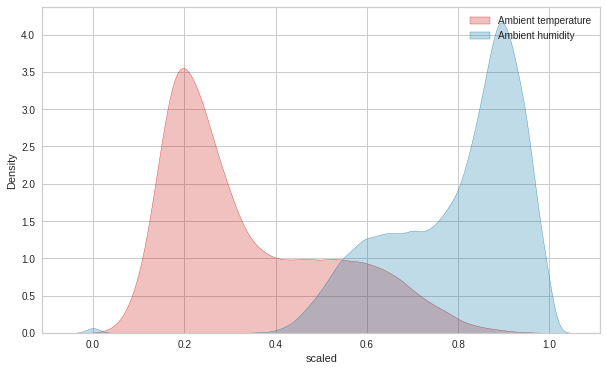

In [ ]:
#density plot
plt.figure(figsize=(10,6))
p1=sns.kdeplot(scaledtemp[:,0], shade=True, color="r",Label='Ambient temperature')
p1=sns.kdeplot(scaledhumid[:,0], shade=True, color="b",label='Ambient humidity')
plt.legend()
plt.xlabel('scaled') 

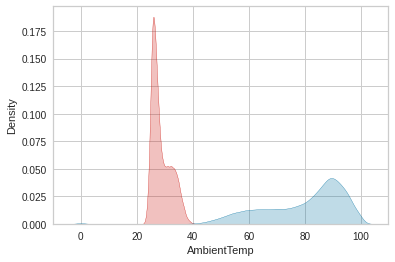

In [ ]:
#density plot
p1=sns.kdeplot(df_combinedAL['AmbientTemp'], shade=True, color="r")
p1=sns.kdeplot(df_combinedAL['AmbientHumid'], shade=True, color="b")

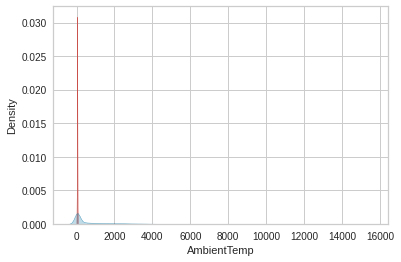

In [ ]:
#density plot
p1=sns.kdeplot(df_combinedAL['AmbientTemp'], shade=True, color="r")
p1=sns.kdeplot(df_combinedAL['LightIntensity'], shade=True, color="b")

In [ ]:
extracthour(df_combinedAL)

In [ ]:
dfmorning.isnull().sum()

DeviceID_x             0
Datetime               0
AmbientTemp            0
CO2                    0
AmbientHumid           0
AmbientPressure        0
DeviceID_y         21447
LightIntensity     21447
hour                   0
dtype: int64

In [ ]:
dfafternoon.isnull().sum()

DeviceID_x             0
Datetime               0
AmbientTemp            0
CO2                    0
AmbientHumid           0
AmbientPressure        0
DeviceID_y         18314
LightIntensity     18314
hour                   0
dtype: int64

In [ ]:
#Discretize hour into bins
bins = [0,4,11,17,18,23]
df_combinedAL['rank_hour']=pd.cut(df_combinedAL['hour'], bins=bins)

In [ ]:
dfevening.hour.value_counts()

21    6528
19    6511
20    6508
22    6502
18    6498
23    6490
Name: hour, dtype: int64

In [ ]:
dfevening.DeviceID.value_counts()

24E124126B261090    4392
24E124126B261286    4382
24E124126B261002    4377
24E124126B263783    4362
24E124126B264083    4358
24E124126B263804    4339
24E124126B260954    4295
24E124126B265398    4292
24E124126B264441    4240
Name: DeviceID, dtype: int64

###Boxplot

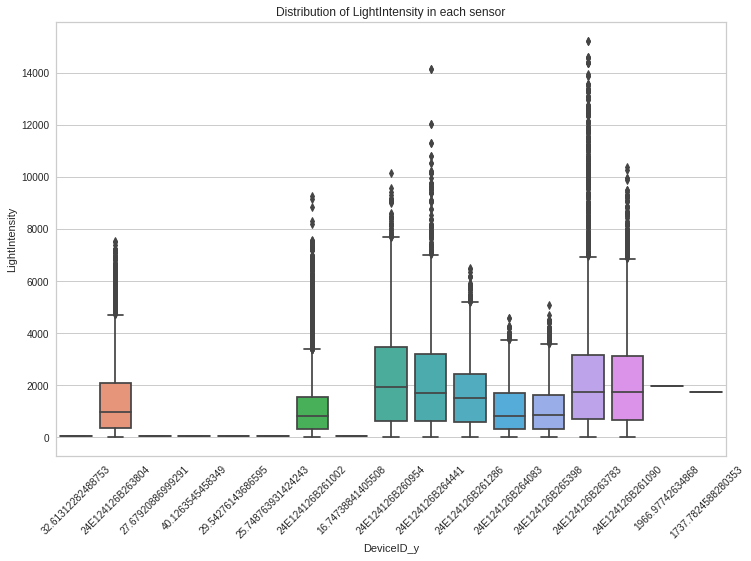

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df_combinedAL, x='DeviceID_y', y='LightIntensity',orient = 'v')
plt.title('Distribution of LightIntensity in each sensor')
plt.xticks(rotation=45)
plt.show()

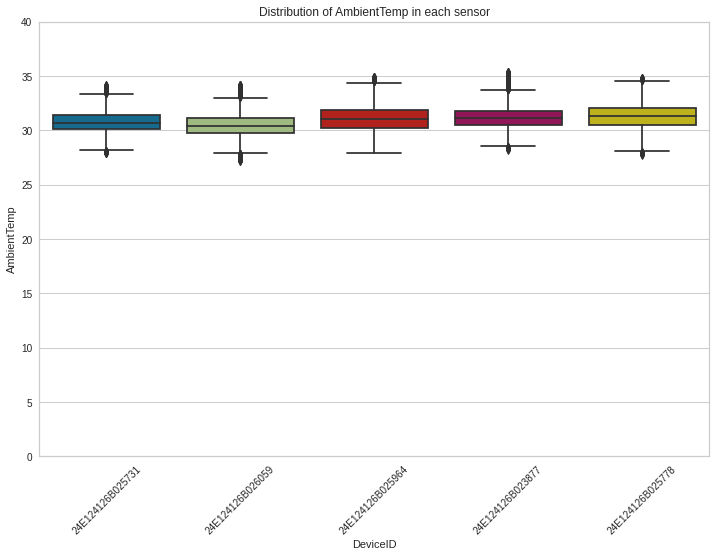

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=dfmidnight, x='DeviceID', y='AmbientTemp',orient = 'v')
plt.title('Distribution of AmbientTemp in each sensor')
plt.ylim(0,40)
plt.xticks(rotation=45)
plt.show()

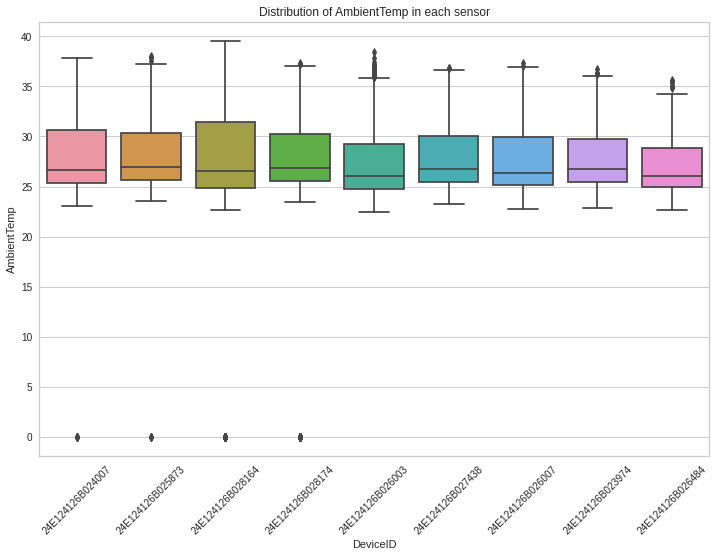

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=dfmorning, x='DeviceID', y='AmbientTemp',orient = 'v')
plt.title('Distribution of AmbientTemp in each sensor')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'AmbientTemp-24E124126B026484')

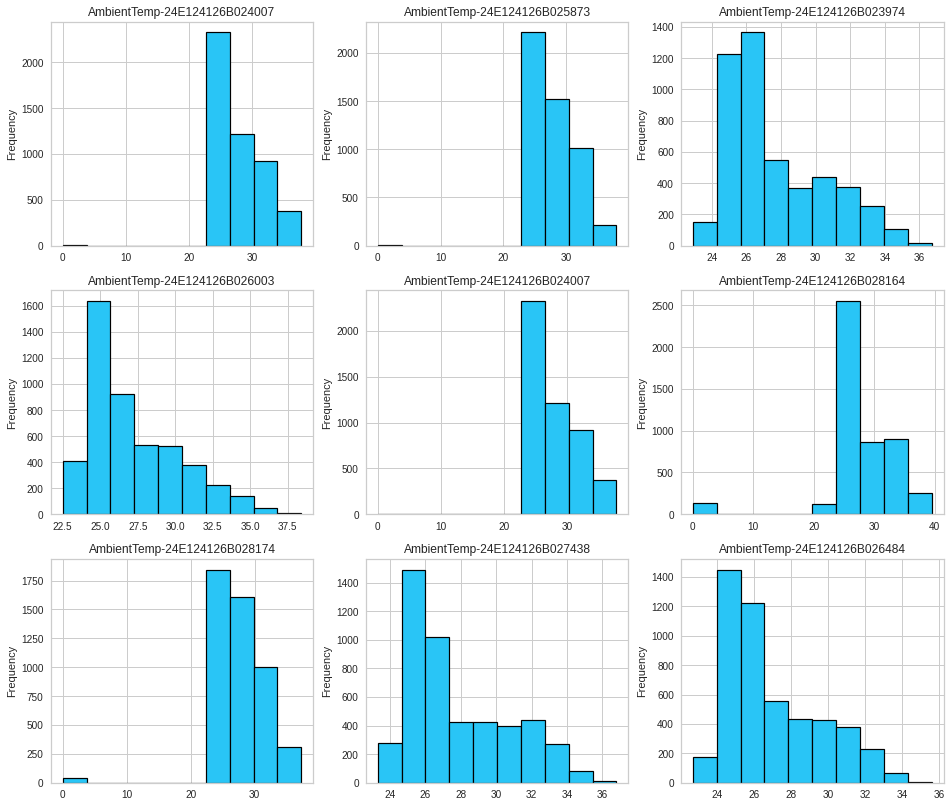

In [ ]:
#Histogram for warehouse (AL)
plt.figure(figsize=(16,14))

#Histogram for loanAmount
plt.subplot(3,3,1)
plt.hist(dfmorning.loc[dfmorning['DeviceID'] == '24E124126B024007']['AmbientTemp'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,5000])
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientTemp-24E124126B024007')

#Histogram for nPaidOff
plt.subplot(3,3,2)
plt.hist(dfmorning.loc[dfmorning['DeviceID'] == '24E124126B025873']['AmbientTemp'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,21])
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientTemp-24E124126B025873')

plt.subplot(3,3,3)
plt.hist(dfmorning.loc[dfmorning['DeviceID'] == '24E124126B023974']['AmbientTemp'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientTemp-24E124126B023974')

plt.subplot(3,3,4)
plt.hist(dfmorning.loc[dfmorning['DeviceID'] == '24E124126B026003']['AmbientTemp'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientTemp-24E124126B026003')

plt.subplot(3,3,5)
plt.hist(dfmorning.loc[dfmorning['DeviceID'] == '24E124126B024007']['AmbientTemp'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientTemp-24E124126B024007')

plt.subplot(3,3,6)
plt.hist(dfmorning.loc[dfmorning['DeviceID'] == '24E124126B028164']['AmbientTemp'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientTemp-24E124126B028164')

plt.subplot(3,3,7)
plt.hist(dfmorning.loc[dfmorning['DeviceID'] == '24E124126B028174']['AmbientTemp'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientTemp-24E124126B028174')

plt.subplot(3,3,8)
plt.hist(dfmorning.loc[dfmorning['DeviceID'] == '24E124126B027438']['AmbientTemp'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientTemp-24E124126B027438')

plt.subplot(3,3,9)
plt.hist(dfmorning.loc[dfmorning['DeviceID'] == '24E124126B026484']['AmbientTemp'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientTemp-24E124126B026484')

In [ ]:
dflight.DeviceID.value_counts()

24E124126B261286    17512
24E124126B261090    17494
24E124126B264083    17457
24E124126B263783    17456
24E124126B261002    17435
24E124126B263804    17334
24E124126B260954    17148
24E124126B265398    17133
24E124126B264441    16926
Name: DeviceID, dtype: int64

In [ ]:
#check frequency of defined lightintensity range
bins = [0,10,20,30,100,200,300,400,500,600,700,800,900,1000,2000,4000,6000,8000,10000,12000]
descritize(dflight,'LightIntensity',bins)

rank
(0, 10]            1014
(10, 20]            879
(20, 30]            861
(30, 100]          4307
(100, 200]         4707
(200, 300]         3928
(300, 400]         3588
(400, 500]         3148
(500, 600]         2961
(600, 700]         2965
(700, 800]         2715
(800, 900]         2706
(900, 1000]        2465
(1000, 2000]      18465
(2000, 4000]      16463
(4000, 6000]       4713
(6000, 8000]       1402
(8000, 10000]       462
(10000, 12000]      167
Name: LightIntensity, dtype: int64


In [ ]:
#Discretize without label
bins = [0,4,11,17,18,23]
df_combinedAL['rank_hour']=pd.cut(df_combinedAL['hour'], bins=bins)

In [ ]:
#Discretize without label
bins = [0,7,11,19,23]
labels=['12a.m.-7a.m','8a.m.-11a.m.','12p.m.-6p.m.','7p.m.-11p.m.']
df_combinedAL['rank_hour']=pd.cut(df_combinedAL['hour'], bins=bins,include_lowest=True,labels=labels)

In [ ]:
#Discretize with label
bins = [0,4,11,17,23]
labels=['midnight', 'morning', 'afternoon','evening']
df_combinedAL['rank_hour']=pd.cut(df_combinedAL['hour'], bins=bins,labels=labels)

In [ ]:
df_test = df_combinedAL.loc[(df_combinedAL['LightIntensity'] == 0)]
df_test.groupby(['DeviceID_y', 'rank_hour']).size().unstack()

rank_hour,12a.m.-7a.m,8a.m.-11a.m.,12p.m.-6p.m.,7p.m.-11p.m.
DeviceID_y,,,,
24E124126B260954,2833,0,359,1614
24E124126B261002,8073,0,959,4434
24E124126B261090,1153,0,96,645
24E124126B261286,3489,0,438,2013
24E124126B263783,2301,6,214,1266
24E124126B263804,1873,0,225,1033
24E124126B264083,2528,0,360,1421
24E124126B264441,2837,0,311,1627
24E124126B265398,3204,0,438,1862


In [ ]:
df_test = df_combinedAL.loc[(df_combinedAL['LightIntensity'] == 0)]
df_test.groupby(['DeviceID_y', 'rank_hour']).size().unstack()

rank_hour
DeviceID_y


In [ ]:
#check frequency of defined lightintensity range
bins = [0,5,10,20,30,40]
descritize(df_combinedAL,'AmbientTemp',bins,include_lowest=True)

rank
(-0.5, 0.0]        698
(0.0, 5.0]           0
(5.0, 10.0]          0
(10.0, 20.0]         0
(20.0, 30.0]    116909
(30.0, 40.0]     50472
Name: AmbientTemp, dtype: int64


In [ ]:
#check zero values in ambient temperature
df_test = df_combinedAL.loc[(df_combinedAL['AmbientTemp'] == 0)]
df_test.groupby(['DeviceID_x', 'rank_hour']).size().unstack()

rank_hour,12a.m.-7a.m,8a.m.-11a.m.,12p.m.-6p.m.,7p.m.-11p.m.
DeviceID_x,,,,
24E124126B023974,0,0,0,9
24E124126B024007,4,3,17,10
24E124126B025873,4,0,4,7
24E124126B026003,7,0,7,10
24E124126B026007,0,0,0,3
24E124126B026484,0,0,7,13
24E124126B027438,0,0,0,8
24E124126B028164,157,68,134,66
24E124126B028174,43,13,70,34


In [ ]:
#check zero values in ambient temperature
df_test = df_combinedAL.loc[(df_combinedAL['AmbientTemp'] == 0)]
df_test.groupby(['DeviceID_x', 'rank_hour']).size().unstack()

rank_hour,12a.m.-7a.m,8a.m.-11a.m.,12p.m.-6p.m.,7p.m.-11p.m.
DeviceID_x,,,,
24E124126B023974,0,0,0,8
24E124126B024007,0,0,0,9
24E124126B025873,0,0,0,3
24E124126B026003,0,0,0,10
24E124126B026484,0,0,0,2
24E124126B027438,0,0,0,3
24E124126B028164,0,0,0,14
24E124126B028174,0,0,5,25


In [ ]:
df_combinedAL.loc[(df_combinedAL['LightIntensity'] == 0)][['DeviceID_y', 'LightIntensity']].groupby(['DeviceID_y', 'LightIntensity']).size()

DeviceID_y        LightIntensity
24E124126B260954  0.0                4816
24E124126B261002  0.0               13505
24E124126B261090  0.0                1899
24E124126B261286  0.0                5949
24E124126B263783  0.0                3787
24E124126B263804  0.0                3186
24E124126B264083  0.0                4336
24E124126B264441  0.0                4781
24E124126B265398  0.0                5509
dtype: int64

In [ ]:
#check which device give zero light intensity
df_combinedAL.loc[(df_combinedAL['LightIntensity'] == 0)][['DeviceID_y','rank_hour','LightIntensity']].groupby(['DeviceID_y','rank_hour','LightIntensity']).size()

DeviceID_y        rank_hour  LightIntensity
24E124126B260954  (0, 4]     0.0               1598
                  (4, 11]    0.0                830
                  (11, 17]   0.0                  0
                  (17, 18]   0.0                  6
                  (18, 23]   0.0               1977
24E124126B261002  (0, 4]     0.0               4471
                  (4, 11]    0.0               2533
                  (11, 17]   0.0                 11
                  (17, 18]   0.0                 41
                  (18, 23]   0.0               5352
24E124126B261090  (0, 4]     0.0                624
                  (4, 11]    0.0                375
                  (11, 17]   0.0                  0
                  (17, 18]   0.0                  0
                  (18, 23]   0.0                746
24E124126B261286  (0, 4]     0.0               2016
                  (4, 11]    0.0                971
                  (11, 17]   0.0                  0
                  (1

In [ ]:
df_test = df_combinedAL.loc[(df_combinedAL['LightIntensity'] == 0)]

In [ ]:
#check light intensity with na
#no NA in dflight, Na appears after combine with ambient
df_test = df_combinedAL.loc[df_combinedAL['LightIntensity'].isna()]
df_test.groupby(['DeviceID_y', 'rank_hour']).size().unstack()

rank_hour
DeviceID_y


In [ ]:
df_test.groupby(['DeviceID_y', 'rank_hour']).size().unstack()

rank_hour,"(0, 4]","(4, 11]","(11, 17]","(17, 18]","(18, 23]"
DeviceID_y,,,,,
24E124126B260954,1598,830,0,6,1977
24E124126B261002,4471,2533,11,41,5352
24E124126B261090,624,375,0,0,746
24E124126B261286,2016,971,0,15,2445
24E124126B263783,1276,707,0,2,1478
24E124126B263804,1050,579,0,2,1287
24E124126B264083,1448,747,0,23,1762
24E124126B264441,1596,843,0,6,1936
24E124126B265398,1807,941,1,27,2277


(array([    0,    10,   100,   200,   300,   400,   500,   600,   700,
          800,   900,  1000,  2000,  4000,  6000,  8000, 10000, 12000]),
 <a list of 18 Text major ticklabel objects>)

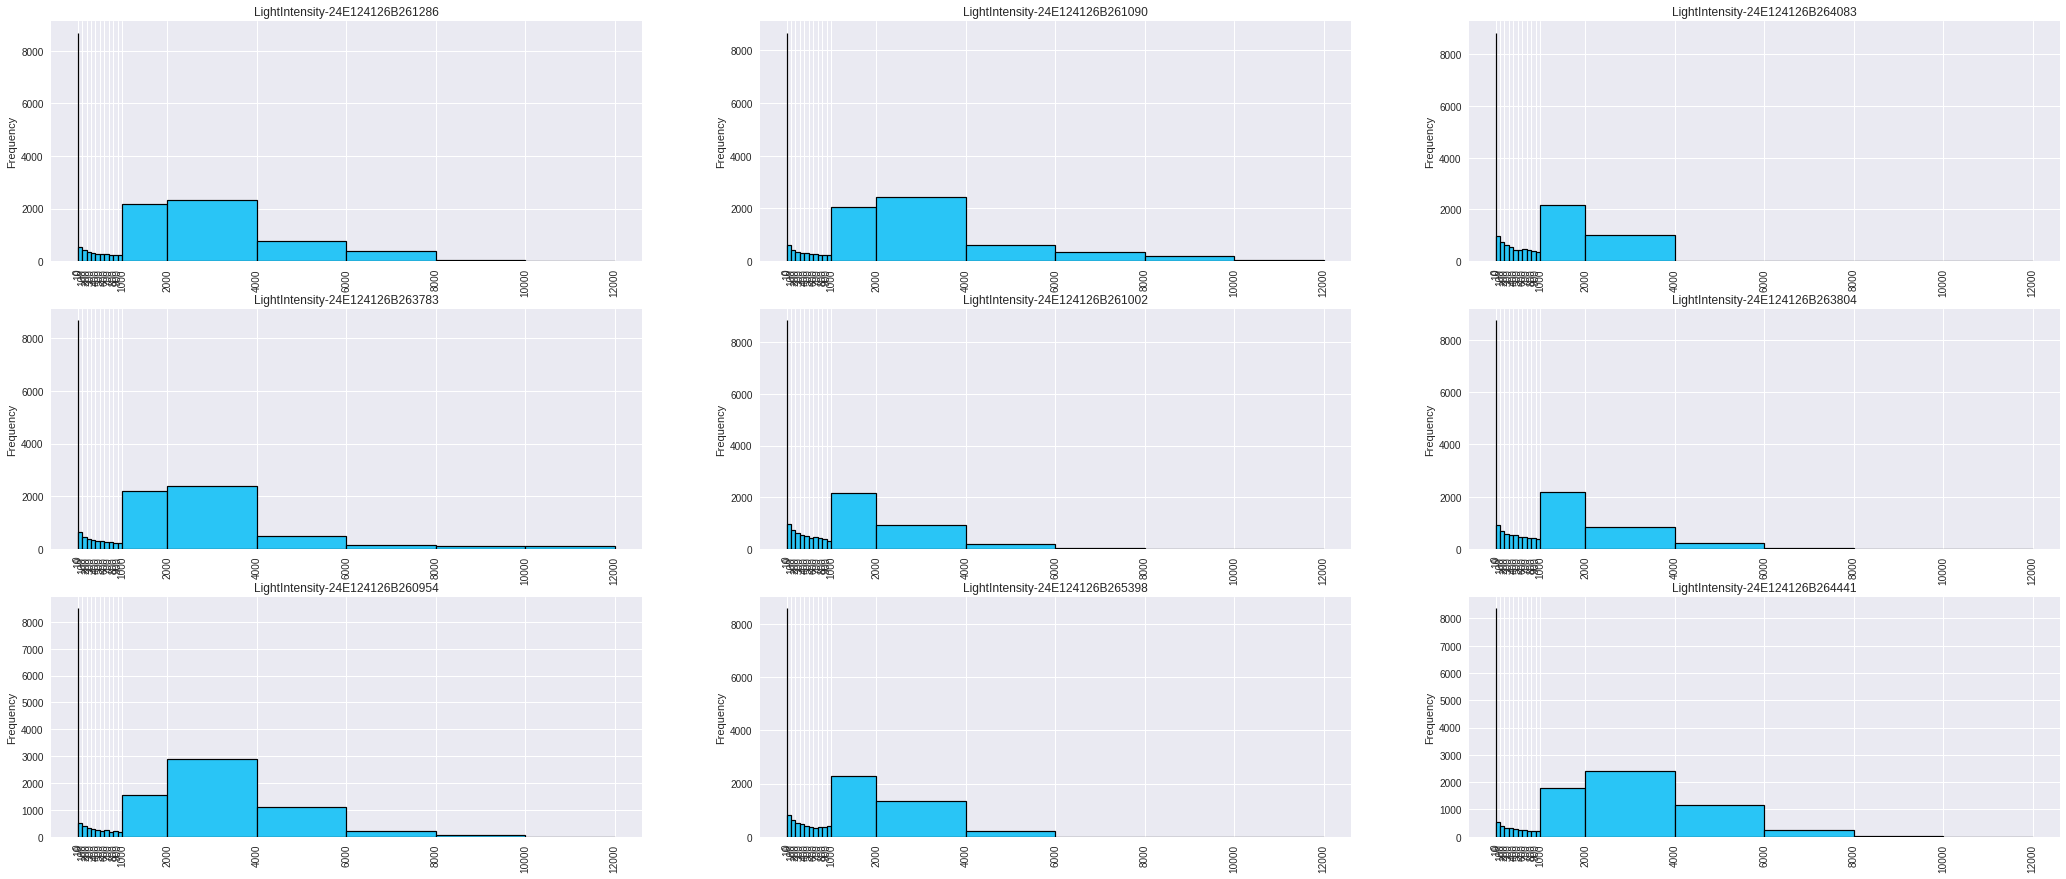

In [ ]:
plt.figure(figsize=(36,15))
bins = [0,10,100,200,300,400,500,600,700,800,900,1000,2000,4000,6000,8000,10000,12000]


plt.subplot(3, 3, 1)
plt.hist(dflight.loc[dflight['DeviceID']=='24E124126B261286']['LightIntensity'], bins=bins,color='#29C5F6',edgecolor='black', linewidth=1.2)
plt.xticks(bins)
plt.ylabel('Frequency')
plt.title('LightIntensity-24E124126B261286')
plt.xticks(rotation=90)

plt.subplot(3, 3, 2)
plt.hist(dflight.loc[dflight['DeviceID']=='24E124126B261090']['LightIntensity'], bins=bins,color='#29C5F6',edgecolor='black', linewidth=1.2)
plt.xticks(bins)
plt.ylabel('Frequency')
plt.title('LightIntensity-24E124126B261090')
plt.xticks(rotation=90)

plt.subplot(3, 3, 3)
plt.hist(dflight.loc[dflight['DeviceID']=='24E124126B264083']['LightIntensity'], bins=bins,color='#29C5F6',edgecolor='black', linewidth=1.2)
plt.xticks(bins)
plt.ylabel('Frequency')
plt.title('LightIntensity-24E124126B264083')
plt.xticks(rotation=90)

plt.subplot(3, 3, 4)
plt.hist(dflight.loc[dflight['DeviceID']=='24E124126B263783']['LightIntensity'], bins=bins,color='#29C5F6',edgecolor='black', linewidth=1.2)
plt.xticks(bins)
plt.ylabel('Frequency')
plt.title('LightIntensity-24E124126B263783')
plt.xticks(rotation=90)

plt.subplot(3, 3, 5)
plt.hist(dflight.loc[dflight['DeviceID']=='24E124126B261002']['LightIntensity'], bins=bins,color='#29C5F6',edgecolor='black', linewidth=1.2)
plt.xticks(bins)
plt.ylabel('Frequency')
plt.title('LightIntensity-24E124126B261002')
plt.xticks(rotation=90)

plt.subplot(3, 3, 6)
plt.hist(dflight.loc[dflight['DeviceID']=='24E124126B263804']['LightIntensity'], bins=bins,color='#29C5F6',edgecolor='black', linewidth=1.2)
plt.xticks(bins)
plt.ylabel('Frequency')
plt.title('LightIntensity-24E124126B263804')
plt.xticks(rotation=90)

plt.subplot(3, 3, 7)
plt.hist(dflight.loc[dflight['DeviceID']=='24E124126B260954']['LightIntensity'], bins=bins,color='#29C5F6',edgecolor='black', linewidth=1.2)
plt.xticks(bins)
plt.ylabel('Frequency')
plt.title('LightIntensity-24E124126B260954')
plt.xticks(rotation=90)

plt.subplot(3, 3, 8)
plt.hist(dflight.loc[dflight['DeviceID']=='24E124126B265398']['LightIntensity'], bins=bins,color='#29C5F6',edgecolor='black', linewidth=1.2)
plt.xticks(bins)
plt.ylabel('Frequency')
plt.title('LightIntensity-24E124126B265398')
plt.xticks(rotation=90)

plt.subplot(3, 3, 9)
plt.hist(dflight.loc[dflight['DeviceID']=='24E124126B264441']['LightIntensity'], bins=bins,color='#29C5F6',edgecolor='black', linewidth=1.2)
plt.xticks(bins)
plt.ylabel('Frequency')
plt.title('LightIntensity-24E124126B264441')
plt.xticks(rotation=90)

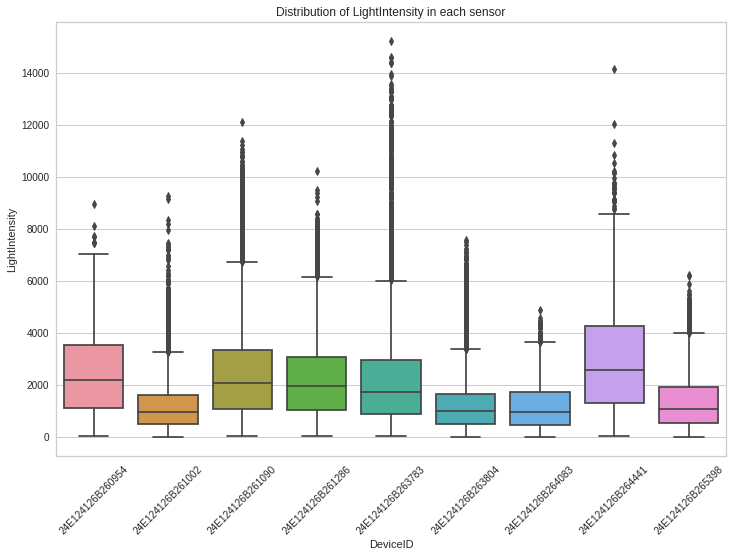

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=dfafternoon, x='DeviceID', y='LightIntensity',orient = 'v')
plt.title('Distribution of LightIntensity in each sensor')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_combinedAL.describe()

,AmbientTemp,CO2,AmbientHumid,AmbientPressure,LightIntensity,hour
count,94899.000000,94899.000000,94899.000000,94899.00000,94899.000000,94899.000000
mean,28.632629,386.046997,79.551934,1007.44131,807.110830,11.517097
std,3.467730,59.225893,14.315934,32.78633,1406.568342,6.939213
min,22.200000,0.000000,0.000000,0.00000,10.000000,0.000000
25%,25.900000,357.000000,69.500000,1007.10000,16.725918,5.000000
50%,27.400000,387.000000,84.000000,1008.60000,40.047935,12.000000
75%,31.100000,420.000000,90.500000,1010.00000,1110.000000,18.000000
max,41.100000,631.000000,100.000000,1016.20000,15210.000000,23.000000


#Normalize

In [ ]:
df_combinedAL['LightIntensity']

In [ ]:
scale = MinMaxScaler() #or StandardScaler()
scaleddata = scale.fit_transform() 

Text(0.5, 0, 'scaled')

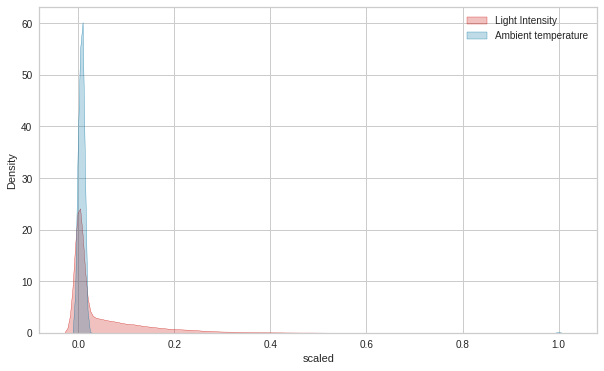

In [ ]:
#density plot
plt.figure(figsize=(10,6))
p1=sns.kdeplot(scaledlight, shade=True, color="r",Label='Light Intensity')
p1=sns.kdeplot(scaledtemp, shade=True, color="b",label='Ambient temperature')
plt.legend()
plt.xlabel('scaled') 

In [ ]:
#scaler = preprocessing.MinMaxScaler()
#scaledlight = scaler.fit_transform(df_combinedAL['LightIntensity'].values)

In [ ]:
x = df_combinedAL['LightIntensity'].values

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))

In [ ]:
df['light'] = pd.DataFrame(x_scaled)

In [ ]:
scaledlight = (df_combinedAL['LightIntensity'] - df_combinedAL['LightIntensity'].min())/ (df_combinedAL['LightIntensity'].max() - df_combinedAL['LightIntensity'].min())
scaledtemp= (df_combinedAL['AmbientTemp'] - df_combinedAL['AmbientTemp'].min())/ (df_combinedAL['AmbientTemp'].max() - df_combinedAL['AmbientTemp'].min())

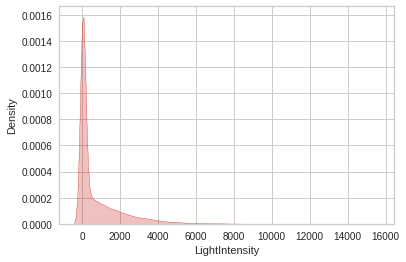

In [ ]:
p1=sns.kdeplot(df_combinedAL['LightIntensity'], shade=True, color="r",Label='Light Intensity')

In [ ]:
df_combinedAL.describe()

,AmbientTemp,CO2,AmbientHumid,AmbientPressure,LightIntensity,hour
count,94899.000000,94899.000000,94899.000000,94899.00000,94899.000000,94899.000000
mean,28.632629,386.046997,79.551934,1007.44131,807.110830,11.517097
std,3.467730,59.225893,14.315934,32.78633,1406.568342,6.939213
min,22.200000,0.000000,0.000000,0.00000,10.000000,0.000000
25%,25.900000,357.000000,69.500000,1007.10000,16.725918,5.000000
50%,27.400000,387.000000,84.000000,1008.60000,40.047935,12.000000
75%,31.100000,420.000000,90.500000,1010.00000,1110.000000,18.000000
max,41.100000,631.000000,100.000000,1016.20000,15210.000000,23.000000


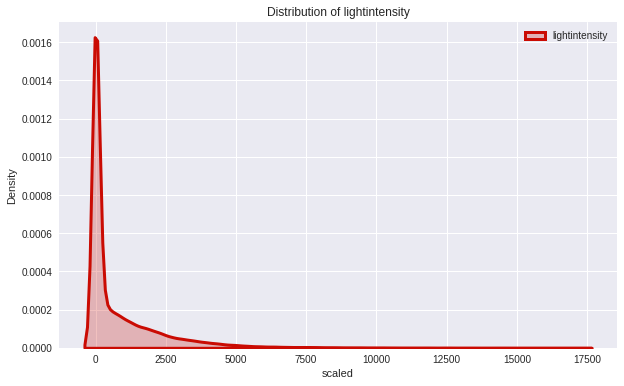

In [ ]:
plt.figure(figsize=(10,6))
p1=sns.kdeplot(dflight['LightIntensity'], shade=True, color="r",linewidth = 3,Label='lightintensity')
plt.legend()
plt.xlabel('scaled') 
plt.title('Distribution of lightintensity')
plt.show()

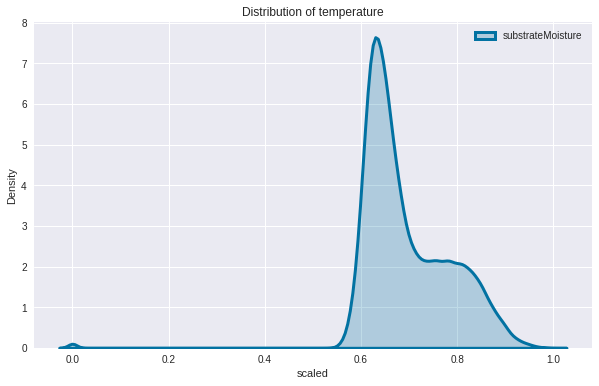

In [ ]:
plt.figure(figsize=(10,6))
p1=sns.kdeplot(scaledtemp, shade=True, color="b",linewidth = 3,label='substrateMoisture')
plt.legend()
plt.xlabel('scaled') 
plt.title('Distribution of temperature')
plt.show()

#Remove outliers

In [ ]:
def outliers(df, feature):
    Q1= df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

In [ ]:
def outlier_removal(df, variable):
    upper_limit = df[variable].mean() + 3 * df[variable].std()
    lower_limit = df[variable].mean() - 3 * df[variable].std()
    return upper_limit, lower_limit

In [ ]:
upper, lower = outliers(dfsoil, "SoilEC")
print("Upper whisker: ", upper)
print("Lower Whisker: ", lower)

Upper whisker:  7660.0
Lower Whisker:  -4596.0


In [ ]:
upper_limit, lower_limit = outlier_removal(dfsoil, "SoilEC")
print("Upper limit: ", upper_limit)
print("Lower Limit: ",lower_limit)

Upper limit:  8825.236094293252
Lower Limit:  -5800.565272741102


In [ ]:
min_threshold, max_threshold = df_combinedRT.SoilEC.quantile([0.001,0.999])
min_threshold,max_threshold

(0.0, 14330.219000000012)

In [ ]:
min_threshold, max_threshold = df_combinedRT.SoilMoisture.quantile([0.001,0.999])
min_threshold,max_threshold

(0.0, 91.09438000000024)

In [ ]:
dfsoil[dfsoil.SoilMoisture<min_threshold]

,DeviceID,Datetime,SoilEC,SoilMoisture,SoilTemp


In [ ]:
dfsoil2 = df_combinedRT[(df_combinedRT.SoilEC<max_threshold) & (df_combinedRT.SoilEC>min_threshold)]
dfsoil2.shape

(18769, 10)

In [ ]:
dfsoil2 = df_combinedRT[(df_combinedRT.SoilMoisture<max_threshold) & (df_combinedRT.SoilMoisture>min_threshold)]
dfsoil2.shape

(84475, 10)

In [ ]:
dfsoil2 = df_combinedRT[(df_combinedRT.SubstrateMoisture<70)]
dfsoil2.shape

(104135, 10)

In [ ]:
dftemplight = df_combinedAL[(df_combinedAL.LightIntensity>0)&(df_combinedAL.AmbientTemp>0)]
dftemplight.shape

(47068, 11)

In [ ]:
dftemplight.loc[(dftemplight['LightIntensity'] == 0)]

,DeviceID_x,Datetime,AmbientTemp,CO2,AmbientHumid,AmbientPressure,DeviceID_y,LightIntensity,hour,rank,rank_hour


In [ ]:
dfsoil2.dropna(inplace=True)

In [ ]:
dfsoil.describe()

,SoilEC,SoilMoisture,SoilTemp
count,252875.000000,252875.000000,252875.000000
mean,1512.335411,17.912655,34.397289
std,2437.633561,17.409550,7.231592
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,30.990000
50%,133.000000,13.610000,33.610000
75%,3064.000000,36.620000,39.030000
max,51115.000000,100.000000,55.750000


In [ ]:
new_df = df[(df['chol'] > lower) & (df['chol'] < upper)]

#Relationship

In [ ]:
def corr(df):
  corrMatrix = df.corr()
  sns.heatmap(corrMatrix,annot=True,cmap="Blues")
  plt.show()

In [ ]:
def best_fit_line(xs,ys):
  slope=(((mean(xs)*mean(ys))-mean(xs*ys))/((mean(xs)*mean(xs))-mean(xs*xs)))
  y_intercept = mean(ys)-slope*mean(xs)
  return slope, y_intercept

In [ ]:
#correlation test between substrate moisture and substrate EC
pearsonr(xs, ys)

(0.8457501293863667, 0.0)

In [ ]:
#correlation test between light intensity and ambient temp
pearsonr(xs, ys)

(0.5997096529227706, 0.0)

In [ ]:
#correlation test between light intensity and ambient pressure
pearsonr(xs, ys)

(0.0074347972399468, 0.02200153219394528)

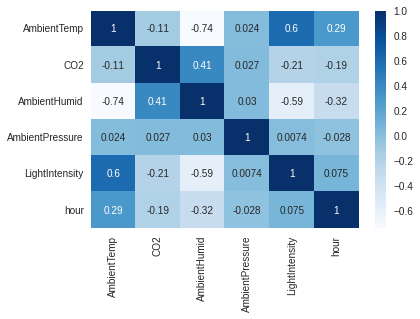

In [ ]:
corr(df_combinedAL)

In [ ]:
xs = df_combinedRT['SubstrateMoisture'].values
ys = df_combinedRT['SubstrateEC'].values

In [ ]:
xs = dfsoil2['SubstrateMoisture'].values
ys = dfsoil2['SubstrateEC'].values

In [ ]:
xs = df_combinedAL['AmbientTemp'].values
ys = df_combinedAL['AmbientHumid'].values  

In [ ]:
xs = df_combinedAL['AmbientTemp'].values
ys = df_combinedAL['LightIntensity'].values  


In [ ]:
xs = df_combinedAL[['AmbientTemp']]
ys = df_combinedAL['LightIntensity']

Text(0.5, 1.0, 'Relationship between AmbientTemp and Ambient')

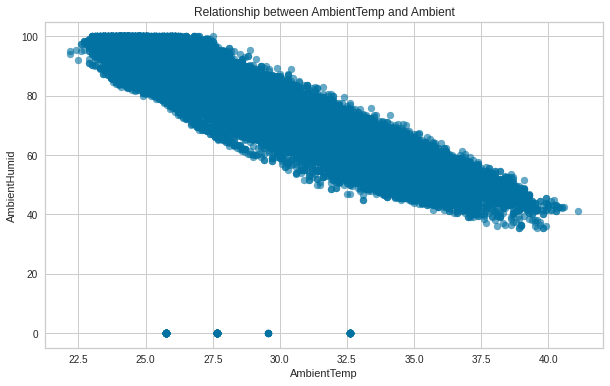

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(xs,ys,alpha=0.6)
plt.xlabel('AmbientTemp')
plt.ylabel('AmbientHumid')
plt.title('Relationship between AmbientTemp and Ambient')

In [ ]:
count = ys.tolist().count(0)
print(count)

0


In [ ]:
df_combinedAL.describe()

,AmbientTemp,CO2,AmbientHumid,AmbientPressure,LightIntensity,hour
count,94899.000000,94899.000000,94899.000000,94899.00000,94899.000000,94899.000000
mean,28.632629,386.046997,79.551934,1007.44131,807.110830,11.517097
std,3.467730,59.225893,14.315934,32.78633,1406.568342,6.939213
min,22.200000,0.000000,0.000000,0.00000,10.000000,0.000000
25%,25.900000,357.000000,69.500000,1007.10000,16.725918,5.000000
50%,27.400000,387.000000,84.000000,1008.60000,40.047935,12.000000
75%,31.100000,420.000000,90.500000,1010.00000,1110.000000,18.000000
max,41.100000,631.000000,100.000000,1016.20000,15210.000000,23.000000


(0.0, 15000.0)

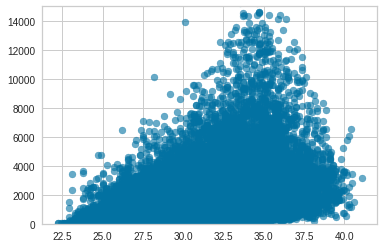

In [ ]:
plt.scatter(xs,ys,alpha=0.6)
plt.ylim(0,15000)

(0.0, 40.0)

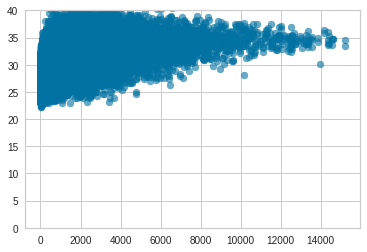

In [ ]:
plt.scatter(xs,ys,alpha=0.6)
plt.ylim(0,40)

In [ ]:
lm = linear_model.LinearRegression()
model = lm.fit(xs.reshape(-1,1), ys)

In [ ]:
y_pred = model.predict(xs.reshape(-1,1))

In [ ]:
soilec_soilmoisture = linear_model.LinearRegression()
soilec_soilmoisture.fit(xs.reshape(-1,1),ys)

In [ ]:
poly = preprocessing.PolynomialFeatures(degree=1)
x_poly = poly.fit_transform(xs.reshape(-1,1))
#poly.fit(x_poly,ys)
poly_reg  = linear_model.LinearRegression()
poly_reg.fit(x_poly,ys)

LinearRegression()

In [ ]:
poly = preprocessing.PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(xs.reshape(-1,1))
#poly.fit(x_poly,ys)
poly_reg  = linear_model.LinearRegression()
poly_reg.fit(x_poly,ys)

In [ ]:
y_pred = poly_reg.predict(x_poly)

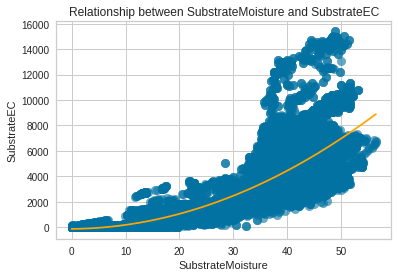

In [ ]:
plt.scatter(xs,ys,alpha=0.6,s=75)
plt.plot(np.sort(xs),np.sort(y_pred),color='orange')
plt.xlabel('SubstrateMoisture')
plt.ylabel('SubstrateEC')
plt.title('Relationship between SubstrateMoisture and SubstrateEC')
plt.legend()
plt.show()

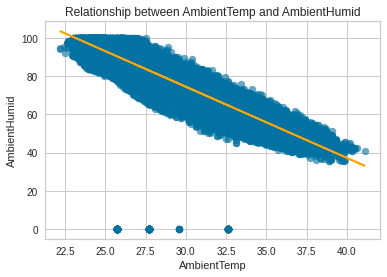

In [ ]:
plt.scatter(xs,ys,alpha=0.6)
plt.plot(xs,y_pred,color='orange')
plt.xlabel('AmbientTemp')
plt.ylabel('AmbientHumid')
plt.title('Relationship between AmbientTemp and AmbientHumid')
plt.legend()
plt.show()

In [ ]:
print(model.intercept_)
print(model.coef_)

186.2912587837145
[-3.72789116]


In [ ]:
theta0 = model.intercept_
theta1 =model.coef_
theta0, theta1

(186.2912587837145, array([-3.72789116]))

In [ ]:
#predict new values
y_new = model.predict([[31]])
y_new

array([70.72663277])

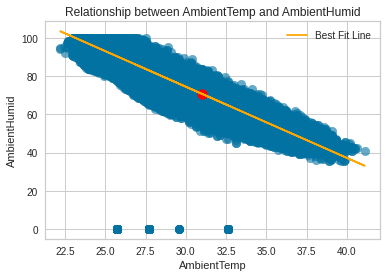

In [ ]:
plt.scatter(xs,ys,alpha=0.6,s=75)
plt.plot(xs,y_pred,label='Best Fit Line',color='orange')
plt.scatter(31, y_new, c = "red",s=100)
plt.xlabel('AmbientTemp')
plt.ylabel('AmbientHumid')
plt.title('Relationship between AmbientTemp and AmbientHumid')
plt.legend()
plt.show()

In [ ]:
print(poly_reg.intercept_)
print(poly_reg.coef_)

-130.47672813565532
[0.         3.88383637 2.77002439]


In [ ]:
theta0 = poly_reg.intercept_
_, theta1, theta2 =poly_reg.coef_
theta0, theta1, theta2

(-130.47672813565532, 3.883836367267175, 2.7700243922902508)

In [ ]:
#predict new values
pred2 = 30
pred2array = np.array([[pred2]])
poly_reg.predict(poly.fit_transform(pred2array))

array([2479.06031594])

In [ ]:
#predict new values
y_new = poly_reg.predict(poly.fit_transform([[30]]))
y_new

array([2479.06031594])

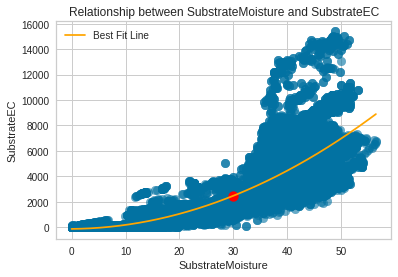

In [ ]:
plt.scatter(xs,ys,alpha=0.6,s=75)
plt.plot(np.sort(xs),np.sort(y_pred),label='Best Fit Line',color='orange')
plt.scatter(30, y_new, c = "red",s=100)
plt.xlabel('SubstrateMoisture')
plt.ylabel('SubstrateEC')
plt.title('Relationship between SubstrateMoisture and SubstrateEC')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ys, y_pred)

1298932.1371866174

In [ ]:
poly_reg_rmse = np.sqrt(mean_squared_error(ys, y_pred))
print(poly_reg_rmse)

1139.7070400706566


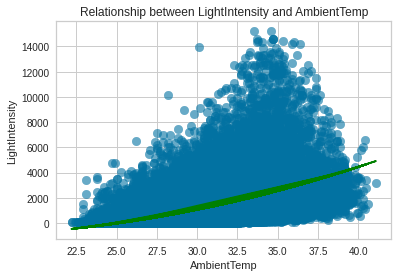

In [ ]:
plt.scatter(xs,ys,alpha=0.6,s=75)
plt.plot(xs,y_pred,color='green')
plt.xlabel('AmbientTemp')
plt.ylabel('LightIntensity')
plt.title('Relationship between LightIntensity and AmbientTemp')
plt.legend()
plt.show()

In [ ]:
plt.scatter(xs,ys,alpha=0.6,s=75)
plt.plot(np.sort(xs),np.sort(y_pred),color='green')
plt.xlabel('AmbientTemp')
plt.ylabel('LightIntensity')
plt.title('Relationship between LightIntensity and AmbientTemp')
plt.legend()
plt.show()

In [ ]:
theta0 = poly_reg.intercept_
_, theta1, theta2 =poly_reg.coef_
theta0, theta1, theta2

(539.879635182745, -224.43664005495285, 8.046429520654328)

In [ ]:
#predict new values
y_new = poly_reg.predict(poly.fit_transform([[25]]))
y_new

array([-42.01791578])

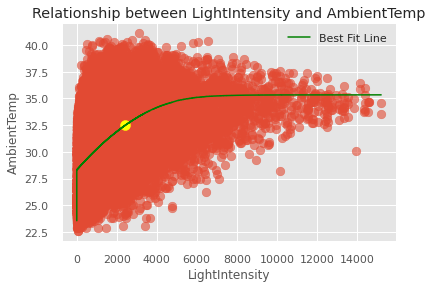

In [ ]:
plt.scatter(xs,ys,alpha=0.6,s=75)
plt.plot(np.sort(xs),np.sort(y_pred),label='Best Fit Line',color='green')
plt.scatter(2400, y_new, c = "yellow",s=100)
plt.xlabel('LightIntensity')
plt.ylabel('AmbientTemp')
plt.title('Relationship between LightIntensity and AmbientTemp')
plt.legend()
plt.show()

In [ ]:
mean_squared_error(ys, y_pred)

8.681418594301528

In [ ]:
poly_reg_rmse = np.sqrt(mean_squared_error(ys, y_pred))
print(poly_reg_rmse)

2.9464247138356563


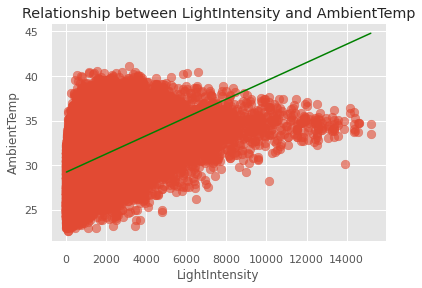

In [ ]:
plt.scatter(xs,ys,alpha=0.6,s=75)
plt.plot(np.sort(xs),np.sort(y_pred),color='green')
plt.xlabel('LightIntensity')
plt.ylabel('AmbientTemp')
plt.title('Relationship between LightIntensity and AmbientTemp')
plt.legend()
plt.show()

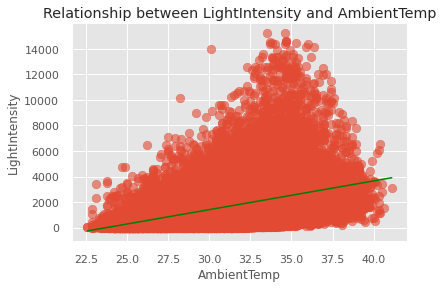

In [ ]:
plt.scatter(xs,ys,alpha=0.6,s=75)
plt.plot(np.sort(xs),np.sort(y_pred),color='green')
plt.xlabel('AmbientTemp')
plt.ylabel('LightIntensity')
plt.title('Relationship between LightIntensity and AmbientTemp')
plt.legend()
plt.show()

In [ ]:
theta0 = poly_reg.intercept_
_, theta1, theta2 =poly_reg.coef_
theta0, theta1, theta2

(-5300.342971932912, 222.22479339927378, 0.042695412896677)

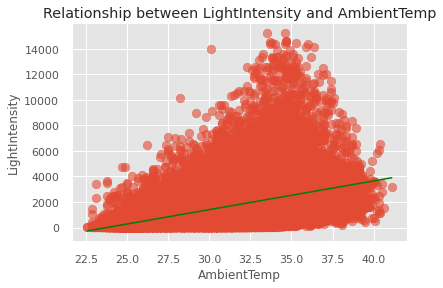

In [ ]:
plt.scatter(xs,ys,alpha=0.6,s=75)
plt.plot(np.sort(xs),np.sort(y_pred),color='green')
plt.xlabel('AmbientTemp')
plt.ylabel('LightIntensity')
plt.title('Relationship between LightIntensity and AmbientTemp')
plt.legend()
plt.show()

In [ ]:
print(poly_reg.intercept_)
print(poly_reg.coef_)

-5340.053371102102
[  0.         224.84648218]


In [ ]:
y_new = poly_reg.predict(poly.fit_transform([[32.5]]))
y_new

array([1967.05984342])

In [ ]:
poly.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1', 'x0', 'x0^2']

In [ ]:
temp_list = df_combinedAL['AmbientTemp'].tolist()
light_list = df_combinedAL['LightIntensity'].tolist()

xs = np.array(temp_list,dtype=np.float64)
ys = np.array(light_list,dtype=np.float64)

In [ ]:
temp_light = linear_model.LinearRegression()
temp_light.fit(xs.reshape(-1,1),ys)
regression_line = temp_light.predict(xs.reshape(-1,1))

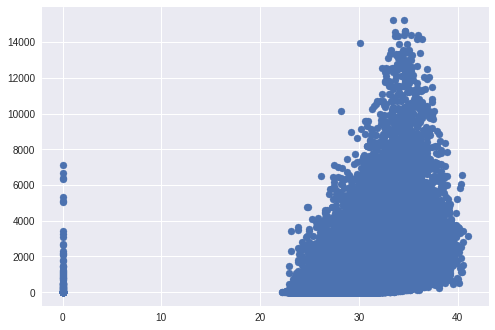

In [ ]:
style.use('seaborn')
plt.scatter(xs,ys)
plt.show()

In [ ]:
def best_fit_line(xs,ys):
  slope=(((mean(xs)*mean(ys))-mean(xs*ys))/((mean(xs)*mean(xs))-mean(xs*xs)))
  y_intercept = mean(ys)-slope*mean(xs)
  return slope, y_intercept

In [ ]:
EC_list = df_combinedRT['SoilEC'].tolist()
Moisture_list = df_combinedRT['SoilMoisture'].tolist()

xs = np.array(Moisture_list,dtype=np.float64)
ys = np.array(EC_list,dtype=np.float64)

In [ ]:
slope,y_intercept = best_fit_line(xs,ys)
regression_line = [(slope*x)+y_intercept for x in xs]

In [ ]:
print(slope)
print(y_intercept)

137.54808751736877
-1117.7163788878197


In [ ]:
soilmoisture = 30
soilec = (slope* soilmoisture)+y_intercept
print(soilec)

3008.726246633243


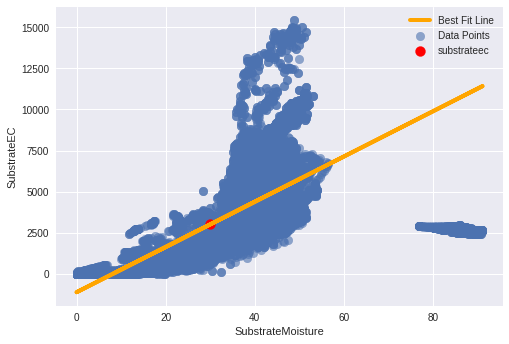

In [ ]:
style.use('seaborn')
plt.scatter(xs,ys,label='Data Points',alpha=0.6,s=75)
plt.scatter(soilmoisture,soilec, label ='substrateec',color='red',s=100)
plt.plot(xs,regression_line,label='Best Fit Line',color='orange',linewidth=4)
plt.xlabel('SubstrateMoisture')
plt.ylabel('SubstrateEC')
plt.legend()
plt.show()

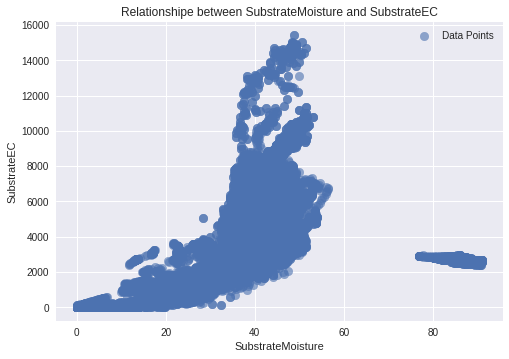

In [ ]:
style.use('seaborn')
plt.scatter(xs,ys,label='Data Points',alpha=0.6,s=75)
plt.xlabel('SubstrateMoisture')
plt.ylabel('SubstrateEC')
plt.title('Relationshipe between SubstrateMoisture and SubstrateEC')
plt.legend()
plt.show()

In [ ]:
#using sklearn library
soilec_soilmoisture = linear_model.LinearRegression()
soilec_soilmoisture.fit(xs.reshape(-1,1),ys)

LinearRegression()

In [ ]:
regression_line = soilec_soilmoisture.predict(xs.reshape(-1,1))

In [ ]:
y_pred = linreg.predict(x_poly)

In [ ]:
sksoilec = 10000
sksoilmoisture=soilec_soilmoisture.predict(np.array([[sksoilec]]))[0] 
print(sksoilmoisture)

68.31841383518466


In [ ]:
xs = df_combinedRT['SubstrateMoisture'].values
ys = df_combinedRT['SubstrateEC'].values

In [ ]:
xs = df_combinedAL['LightIntensity'].values
ys = df_combinedAL['AmbientPressure'].values

In [ ]:
poly = preprocessing.PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(xs.reshape(-1,1))
#poly.fit(x_poly,ys)
poly_reg  = linear_model.LinearRegression()
poly_reg.fit(x_poly,ys)

LinearRegression()

In [ ]:
print(poly_reg.intercept_)
print(poly_reg.coef_)


In [ ]:
y_pred = poly_reg.predict(x_poly)

In [ ]:
#remove soilmoisture above 60

In [ ]:
df_soil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252878 entries, 0 to 252877
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DeviceID      252878 non-null  object        
 1   Datetime      252878 non-null  datetime64[ns]
 2   SoilEC        252878 non-null  float64       
 3   SoilMoisture  252878 non-null  float64       
 4   SoilTemp      252878 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 9.6+ MB


#Hypothesis testing


In [ ]:
def one_sample_one_tailed(data, popmean, alpha=0.05, alternative='greater'):
    t, p = ttest_1samp(data, popmean)
    print("t Statistic: ", tscore)  
    print("P Value: ", pvalue)  
    if alternative == 'greater' and (p/2 < alpha) and t > 0:
        print ('Reject Null Hypothesis for greater-than test')
    if alternative == 'less' and (p/2 < alpha) and t < 0:
        print ('Reject Null Hypothesis for less-than test')

In [ ]:
#H0: The temperature in the insectory is not greater than 24
#H1: The temperature in the insectory is greater than 24
a =  dfambient['AmbientTemp'].values
one_sample_one_tailed(a,24,0.05)

t Statistic:  377.4652635720321
P Value:  0.0
Reject Null Hypothesis for greater-than test


In [ ]:
#H0: The temperature in the insectory is not less than 40
#H1: The temperature in the insectory is less than 40
a =  dfambient['AmbientTemp'].values
one_sample_one_tailed(a,40,0.05)

t Statistic:  377.4652635720321
P Value:  0.0
Reject Null Hypothesis for less-than test


In [ ]:
tscore, pvalue=ttest_1samp(a, popmean=24,alternative='greater')

In [ ]:
#Welch’s t-Test no assumption of two sample have equal variance
ttest_ind(group1['score'], group2['score'], equal_var=False)

In [ ]:
#Independent Two Sample t-Test
ttest_ind(group1['score'], group2['score'])

In [ ]:
from scipy import stats
def one_sample_one_tailed(sample_data, popmean, alpha=0.05, alternative='less'):
    t, p = stats.ttest_1samp(sample_data, popmean)
    print ('t:',t)
    print ('p:',p)
    if alternative == 'greater' and (p/2 < alpha) and t > 0:
        print ('Reject Null Hypothesis for greater-than test')
    if alternative == 'less' and (p/2 < alpha) and t < 0:
        print ('Reject Null Hypothesis for less-than test')

In [ ]:
df_combinedAL.drop(['DeviceID_x','DeviceID_y'], axis = 1, inplace = True)

In [ ]:
df_combinedRT.drop(['DeviceID_x','DeviceID_y'], axis = 1, inplace = True)

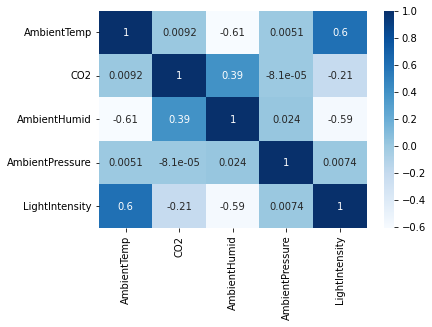

In [ ]:
#correlation of environmental variables in insectary
corrMatrix = df_combinedAL.corr()
sns.heatmap(corrMatrix, annot=True,cmap="Blues")
plt.show()

In [ ]:
df_combinedRT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104782 entries, 1 to 141829
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   DeviceID_x       104782 non-null  object 
 1   Datetime         104782 non-null  object 
 2   AmbientTemp      104782 non-null  float64
 3   CO2              104782 non-null  float64
 4   AmbientHumid     104782 non-null  float64
 5   AmbientPressure  104782 non-null  float64
 6   DeviceID_y       104782 non-null  object 
 7   SoilEC           104782 non-null  float64
 8   SoilMoisture     104782 non-null  float64
 9   SoilTemp         104782 non-null  float64
dtypes: float64(7), object(3)
memory usage: 8.8+ MB


In [ ]:
df_combinedRT.rename(columns={'SoilMoisture':'SubstrateMoisture'}, inplace=True)
df_combinedRT.rename(columns={'SoilEC':'SubstrateEC'}, inplace=True)
df_combinedRT.rename(columns={'SoilTemp':'SubstrateTemp'}, inplace=True)

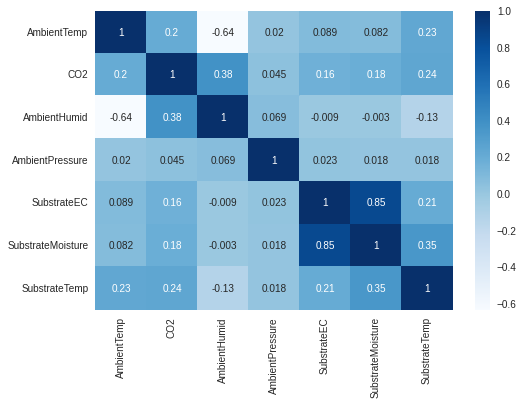

In [ ]:
#correlation of environmental variables in warehouse
corrMatrix = df_combinedRT.corr()
sns.heatmap(corrMatrix, annot=True,cmap="Blues")
plt.show()

In [ ]:
df_combinedAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168107 entries, 0 to 168106
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   DeviceID_x       168107 non-null  object 
 1   Datetime         168107 non-null  object 
 2   AmbientTemp      168107 non-null  float64
 3   CO2              168107 non-null  int64  
 4   AmbientHumid     168107 non-null  float64
 5   AmbientPressure  168107 non-null  float64
 6   DeviceID_y       94899 non-null   object 
 7   LightIntensity   94899 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 11.5+ MB


#Relationship


In [ ]:
def correlation_test(df):
    pearson_stat = df.corr(method=lambda x, y: stats.pearsonr(x, y)[0])
    pearson_p = df.corr(method=lambda x, y: stats.pearsonr(x, y)[1])
    spearman_stat = df.corr(method=lambda x, y: stats.spearmanr(x, y)[0])
    spearman_p = df.corr(method=lambda x, y: stats.spearmanr(x, y)[1])

    pearson_p = (pearson_p - np.eye(df.shape[1])).round(4)
    spearman_p = (spearman_p - np.eye(df.shape[1])).round(4)

    return pearson_stat, pearson_p, spearman_stat, spearman_p

In [ ]:
substrateEC_norm = (dfambientRT['SoilEC'] - dfambientRT['SoilEC'].min())/ (dfambientRT['SoilEC'].max() - dfambientRT['SoilEC'].min())

In [ ]:
def normalize(df,column):
  (df['column'] - df['column'].min())/(df['column'].max() - df['column'].min())

In [ ]:
scaledlight= (df_combinedAL['LightIntensity'] - df_combinedAL['LightIntensity'].min())/ (df_combinedAL['LightIntensity'].max() -df_combinedAL['LightIntensity'].min())

In [ ]:
scaledtemp = (df_combinedAL['AmbientTemp'] - df_combinedAL['AmbientTemp'].min())/ (df_combinedAL['AmbientTemp'].max() -df_combinedAL['AmbientTemp'].min())

In [ ]:
dfsoil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252875 entries, 0 to 252877
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   DeviceID      252875 non-null  object        
 1   Datetime      252875 non-null  datetime64[ns]
 2   SoilEC        252875 non-null  float64       
 3   SoilMoisture  252875 non-null  float64       
 4   SoilTemp      252875 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 11.6+ MB


In [ ]:
scaledec = (dfsoil['SoilEC'] - dfsoil['SoilEC'].min())/ (dfsoil['SoilEC'].max() - dfsoil['SoilEC'].min())
scaledmoisture = (dfsoil['SoilMoisture'] - dfsoil['SoilMoisture'].min())/ (dfsoil['SoilMoisture'].max() - dfsoil['SoilMoisture'].min())

In [ ]:
scaledec = (df_combinedRT['SoilEC'] - df_combinedRT['SoilEC'].min())/ (df_combinedRT['SoilEC'].max() - df_combinedRT['SoilEC'].min())
scaledmoisture = (df_combinedRT['SoilMoisture'] - df_combinedRT['SoilMoisture'].min())/ (df_combinedRT['SoilMoisture'].max() - df_combinedRT['SoilMoisture'].min())

In [ ]:
scaledec = (dfsoil2['SoilEC'] - dfsoil2['SoilEC'].min())/ (dfsoil2['SoilEC'].max() - dfsoil2['SoilEC'].min())
scaledmoisture = (dfsoil2['SoilMoisture'] - dfsoil2['SoilMoisture'].min())/ (dfsoil2['SoilMoisture'].max() - dfsoil2['SoilMoisture'].min())

In [ ]:
p1=sns.kdeplot(df_combinedAL['AmbientTemp'], shade=True, color="r")
p1=sns.kdeplot(df_combinedAL['LightIntensity'], shade=True, color="b")

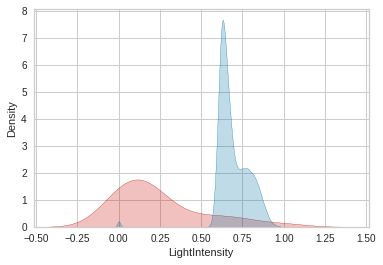

In [ ]:
p1=sns.kdeplot(scaledlight, shade=True, color="r")
p1=sns.kdeplot(scaledtemp, shade=True, color="b")

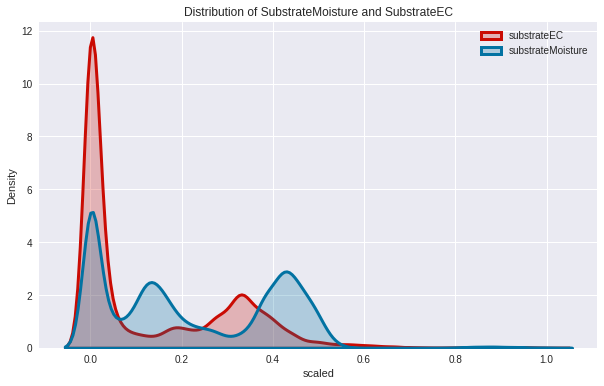

In [ ]:
plt.figure(figsize=(10,6))
p1=sns.kdeplot(scaledec, shade=True, color="r",linewidth = 3,Label='substrateEC')
p1=sns.kdeplot(scaledmoisture, shade=True, color="b",linewidth = 3,label='substrateMoisture')
plt.legend()
plt.xlabel('scaled') 
plt.title('Distribution of SubstrateMoisture and SubstrateEC')
plt.show()

In [ ]:
dfre['SoilEC'] = dfambientRT['SoilEC'].apply(lambda x:x.min()/x.max()-x.min())

In [ ]:
temp_list = df_combinedAL['AmbientTemp'].tolist()
light_list = df_combinedAL['LightIntensity'].tolist()

xs = np.array(temp_list,dtype=np.float64)
ys = np.array(light_list,dtype=np.float64)

NameError: ignored

In [ ]:
temp_light = linear_model.LinearRegression()
temp_light.fit(xs.reshape(-1,1),ys)
regression_line = temp_light.predict(xs.reshape(-1,1))

In [ ]:
style.use('seaborn')
plt.scatter(xs,ys)
plt.show()

In [ ]:
AL_fit = np.polyfit(df_combinedAL.AmbientTemp, df_combinedAL.LightIntensity, 1)

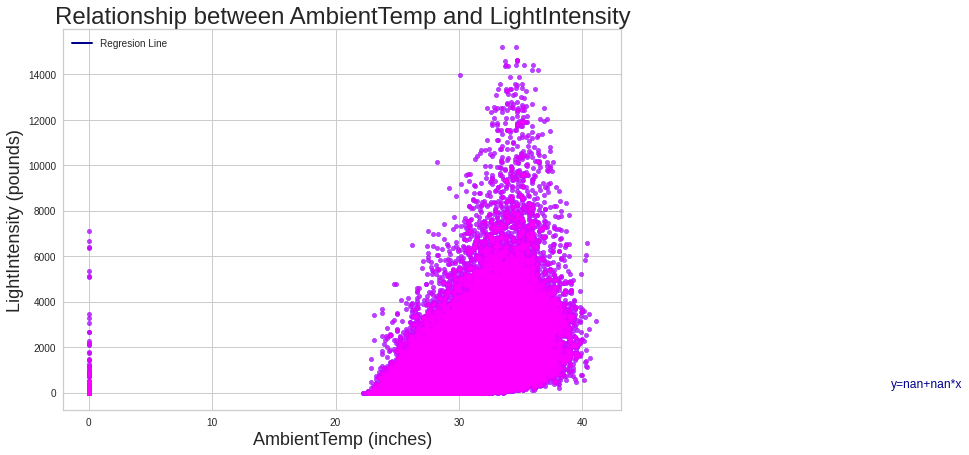

In [ ]:
# males and females dataframes
#df_males = df[df['Gender'] == 'Male']
#df_females = df[df['Gender'] == 'Female']

# Scatter plots.
ax1 = df_combinedAL.plot(kind='scatter', x='AmbientTemp', y='LightIntensity', color='blue', alpha=0.5, figsize=(10, 7))
df_combinedAL.plot(kind='scatter', x='AmbientTemp', y='LightIntensity', color='magenta', alpha=0.5, figsize=(10, 7), ax=ax1)

# regression lines
plt.plot(df_combinedAL.AmbientTemp, AL_fit[0] * df_combinedAL.AmbientTemp + AL_fit[1], color='darkblue', linewidth=2)

# regression equations
plt.text(65, 230, 'y={:.2f}+{:.2f}*x'.format(AL_fit[1], AL_fit[0]), color='darkblue', size=12)

# legend, title and labels.
plt.legend(labels=['Regresion Line'])
plt.title('Relationship between AmbientTemp and LightIntensity', size=24)
plt.xlabel('AmbientTemp (inches)', size=18)
plt.ylabel('LightIntensity (pounds)', size=18);

In [ ]:
dfambient['AmbientTemp']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ae4183e10>,
      dtype=object)

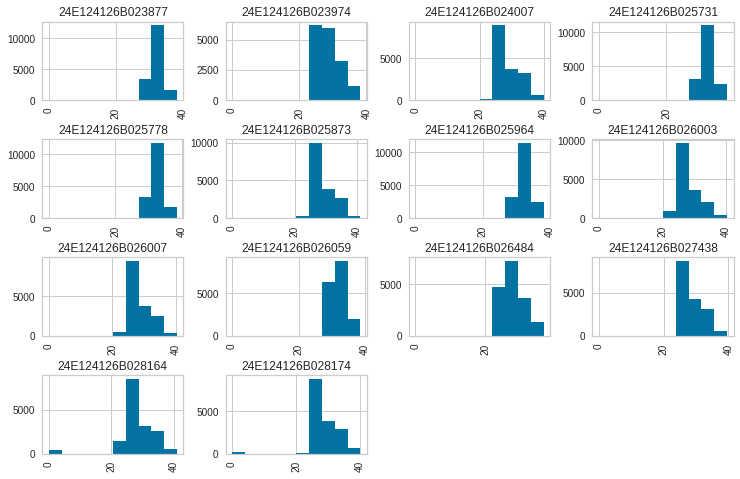

In [ ]:
dfambient.AmbientTemp.hist(by=dfambient.DeviceID,figsize=(12,8))

In [ ]:
normalized_arr = preprocessing.normalize(dfambient.AmbientTemp])
print(normalized_arr)

##Clustering

In [ ]:
#clustering
#determine the number of clusters
def elbowPlot(range_, data, figsize=(10,10)):
    '''
    the elbow plot function helps to figure out the right amount of clusters for a dataset
    '''
    inertia_list = []
    for n in range_:
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        inertia_list.append(kmeans.inertia_)
        
    # plotting
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=inertia_list, x=range_, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range_))
    fig.show()
    #fig.savefig("elbow_plot.png")


In [ ]:
df_combinedAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168107 entries, 0 to 168106
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   DeviceID_x       168107 non-null  object        
 1   Datetime         168107 non-null  datetime64[ns]
 2   AmbientTemp      168107 non-null  float64       
 3   CO2              168107 non-null  float64       
 4   AmbientHumid     168107 non-null  float64       
 5   AmbientPressure  168107 non-null  float64       
 6   hour_x           168107 non-null  int64         
 7   DeviceID_y       94899 non-null   object        
 8   LightIntensity   94899 non-null   float64       
 9   hour_y           94899 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 14.1+ MB


In [ ]:
dftest = df_combinedAL[['hour_x','LightIntensity','AmbientTemp']]

In [ ]:
df_combinedAL.drop(['Datetime'], axis = 1, inplace = True)

In [ ]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94899 entries, 0 to 168106
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hour_x          94899 non-null  int64  
 1   LightIntensity  94899 non-null  float64
 2   AmbientTemp     94899 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 2.9 MB


In [ ]:
dftest.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


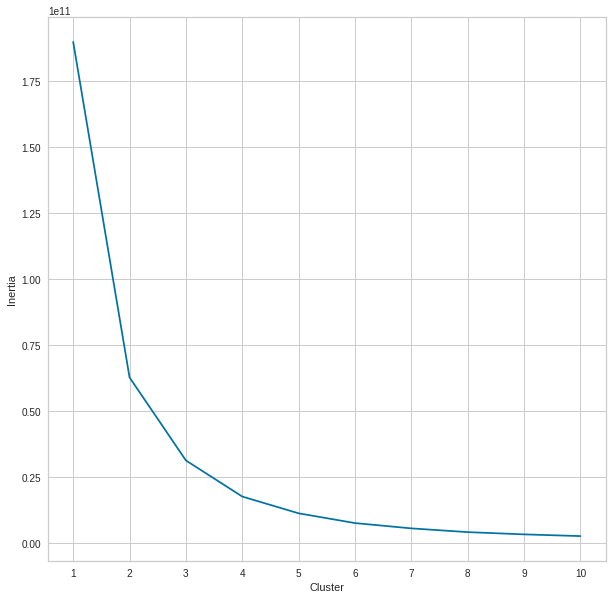

In [ ]:
elbowPlot(range(1,11),dftest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


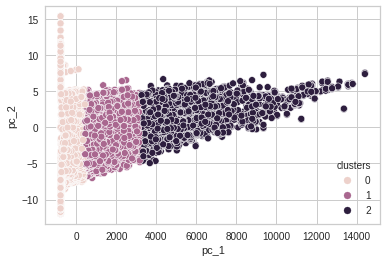

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(dftest)
dftest["clusters"] = cluster_labels

# using PCA to reduce the dimensionality
pca = PCA(n_components=2, whiten=False, random_state=42)
environment_standardized_pca = pca.fit_transform(dftest)
df_environment_standardized_pca = pd.DataFrame(data=environment_standardized_pca, columns=["pc_1", "pc_2"])
df_environment_standardized_pca["clusters"] = cluster_labels

# plotting the clusters with seaborn
sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=df_environment_standardized_pca)

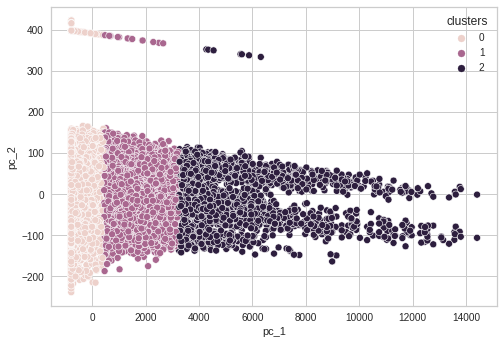

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(df_combinedAL)
df_combinedAL["clusters"] = cluster_labels

# using PCA to reduce the dimensionality
pca = PCA(n_components=2, whiten=False, random_state=42)
environment_standardized_pca = pca.fit_transform(df_combinedAL)
df_environment_standardized_pca = pd.DataFrame(data=environment_standardized_pca, columns=["pc_1", "pc_2"])
df_environment_standardized_pca["clusters"] = cluster_labels

# plotting the clusters with seaborn
sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=df_environment_standardized_pca)

In [ ]:
dftest.iloc[df_environment_standardized_pca[df_environment_standardized_pca["clusters"] == 0].index].describe()

,hour_x,LightIntensity,AmbientTemp,clusters
count,72759.000000,72759.000000,72759.000000,72759.0
mean,11.265933,169.470031,27.308623,0.0
std,7.807153,315.454422,2.930466,0.0
min,0.000000,0.000000,0.000000,0.0
25%,4.000000,0.000000,25.600000,0.0
50%,9.000000,0.000000,26.700000,0.0
75%,19.000000,180.000000,28.400000,0.0
max,23.000000,1210.000000,40.400000,0.0


In [ ]:
dftest.iloc[df_environment_standardized_pca[df_environment_standardized_pca["clusters"] == 1].index].describe()

,hour_x,LightIntensity,AmbientTemp,clusters
count,18524.000000,18524.000000,18524.000000,18524.0
mean,12.298586,2256.800907,32.536558,1.0
std,2.377116,759.326663,3.040506,0.0
min,7.000000,1220.000000,0.000000,1.0
25%,10.000000,1620.000000,30.600000,1.0
50%,12.000000,2100.000000,32.800000,1.0
75%,14.000000,2800.000000,34.600000,1.0
max,18.000000,4020.000000,41.100000,1.0


In [ ]:
dftest.iloc[df_environment_standardized_pca[df_environment_standardized_pca["clusters"] == 2].index].describe()

,hour_x,LightIntensity,AmbientTemp,clusters
count,3616.000000,3616.000000,3616.000000,3616.0
mean,12.567478,5790.580752,33.570603,2.0
std,1.689078,1924.657156,2.632476,0.0
min,8.000000,4030.000000,0.000000,2.0
25%,11.000000,4477.500000,32.200000,2.0
50%,12.000000,5130.000000,33.700000,2.0
75%,14.000000,6380.000000,35.100000,2.0
max,17.000000,15210.000000,40.400000,2.0


In [ ]:
df_combinedRT.drop(['Datetime'], axis = 1, inplace = True)

In [ ]:
df_combinedRT.dropna(inplace=True)

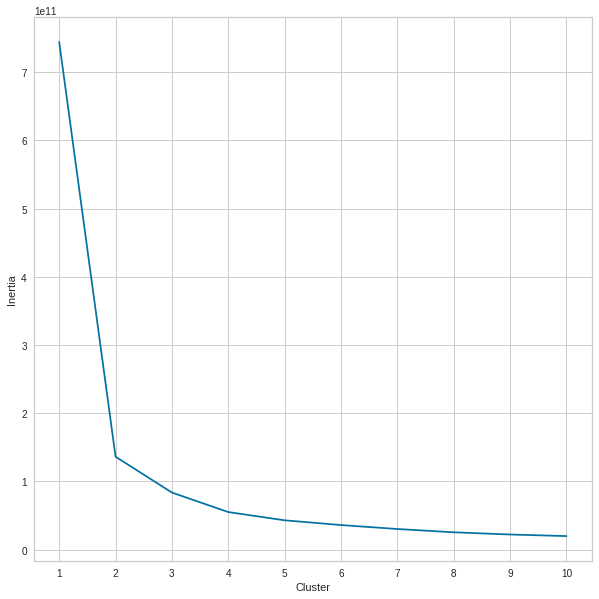

In [ ]:
elbowPlot(range(1,11),df_combinedRT)

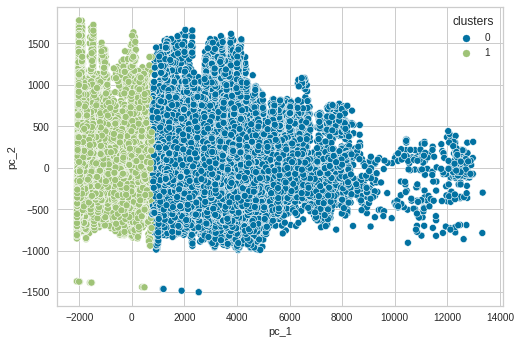

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(df_combinedRT)
df_combinedRT["clusters"] = cluster_labels

# using PCA to reduce the dimensionality
pca = PCA(n_components=2, whiten=False, random_state=42)
environment_standardized_pca = pca.fit_transform(df_combinedRT)
df_environment_standardized_pca = pd.DataFrame(data=environment_standardized_pca, columns=["pc_1", "pc_2"])
df_environment_standardized_pca["clusters"] = cluster_labels

# plotting the clusters with seaborn
sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=df_environment_standardized_pca)

In [ ]:
df_combinedRT.iloc[df_environment_standardized_pca[df_environment_standardized_pca["clusters"] == 0].index].describe()

,AmbientTemp,CO2,AmbientHumid,AmbientPressure,SoilEC,SoilMoisture,SoilTemp,clusters
count,36319.000000,36319.000000,36319.000000,36319.000000,36319.000000,36319.000000,36319.000000,36319.0
mean,32.368482,1524.580715,90.365208,1009.060657,5370.724965,42.384921,37.185358,0.0
std,1.901518,457.402436,7.277901,15.112659,1582.408432,5.323253,5.066668,0.0
min,0.000000,0.000000,0.000000,0.000000,2815.000000,15.430000,23.070000,0.0
25%,31.000000,1178.000000,85.500000,1008.000000,4406.000000,39.180000,32.560000,0.0
50%,32.300000,1475.000000,92.500000,1009.400000,5162.000000,42.130000,37.020000,0.0
75%,33.700000,1757.000000,96.000000,1010.800000,6028.000000,45.270000,41.780000,0.0
max,38.600000,3147.000000,100.000000,1014.900000,15410.000000,87.320000,49.350000,0.0


In [ ]:
df_combinedRT.iloc[df_environment_standardized_pca[df_environment_standardized_pca["clusters"] == 1].index].describe()

,AmbientTemp,CO2,AmbientHumid,AmbientPressure,SoilEC,SoilMoisture,SoilTemp,clusters
count,68463.000000,68463.000000,68463.000000,68463.000000,68463.000000,68463.000000,68463.000000,68463.0
mean,31.980495,1376.420402,90.674795,1008.416104,310.669515,10.629926,34.586252,1.0
std,1.985107,413.792683,7.235201,14.051053,614.085331,12.137668,5.957560,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,30.500000,1077.000000,86.500000,1007.200000,0.000000,0.000000,31.130000,1.0
50%,31.700000,1299.000000,93.000000,1008.700000,25.000000,9.370000,33.230000,1.0
75%,33.300000,1600.000000,96.000000,1010.200000,291.000000,16.090000,37.410000,1.0
max,38.600000,3147.000000,100.000000,1014.900000,2862.000000,97.420000,55.750000,1.0


In [ ]:
dfsoil2 = dfsoil.loc[dfsoil['DeviceID'] == 'A840417211839BE2']

In [ ]:
dfambient['DeviceID'].value_counts()

24E124126B025964    17036
24E124126B023877    17021
24E124126B026484    17010
24E124126B025873    17004
24E124126B026059    16975
24E124126B025778    16661
24E124126B024007    16639
24E124126B027438    16626
24E124126B023974    16582
24E124126B026003    16549
24E124126B025731    16540
24E124126B028164    16537
24E124126B028174    16523
24E124126B026007    16447
Name: DeviceID, dtype: int64

In [ ]:
dflight['DeviceID'].value_counts()

24E124126B261286    17512
24E124126B261090    17494
24E124126B264083    17457
24E124126B263783    17456
24E124126B261002    17435
24E124126B263804    17334
24E124126B260954    17148
24E124126B265398    17133
24E124126B264441    16926
Name: DeviceID, dtype: int64

In [ ]:
dfsoil['DeviceID'].value_counts()

A840417211839BE2    17503
A840415F81839BEF    17502
A840416E71839BF4    17498
A840414F51839BF1    17486
A840419E31839BF5    17481
A84041A111839BED    17477
A8404174B1839BEB    17473
A840413F31839BEE    17466
A8404136E1839BE6    17463
A840412FE1839BE8    17451
A84041F3E1839BEC    17446
A84041DAD1839BE4    17367
A840411481839BF3    17364
A84041FF51839BF2    13831
A84041E1E1839BE3    12067
Name: DeviceID, dtype: int64

In [ ]:
def dropcolumn(df,columnlist):
    df = df.drop(columnlist,axis=1,inplace=True)
    return df

In [ ]:
dropcolumn(df_ambient,['DeviceID'])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dropcolumn(df_soil,['DeviceID'])

In [ ]:
dropcolumn(df_light,['DeviceID'])

In [ ]:
df_combined_2 = pd.merge(pd.merge(dfambient,dflight, left_on='Datetime', right_on='Datetime', how='outer'),dfsoil2,on='Datetime',how='outer')

In [ ]:
df_combined3 = pd.merge(pd.merge(dfambient,dflight, left_on='Datetime', right_on='Datetime', how='left'),dfsoil,on='Datetime',how='left')

In [ ]:
df_combined_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481820 entries, 0 to 481819
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Datetime         481820 non-null  object 
 1   AmbientTemp      481820 non-null  float64
 2   CO2              481820 non-null  int64  
 3   AmbientHumid     481820 non-null  float64
 4   AmbientPressure  481820 non-null  float64
 5   LightIntensity   283912 non-null  float64
 6   SoilEC           383572 non-null  float64
 7   SoilMoisture     383572 non-null  float64
 8   SoilTemp         383572 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 36.8+ MB


In [ ]:
df_combined_3.drop(['DeviceID_x','DeviceID_y','DeviceID'], axis = 1, inplace = True)

In [ ]:
dflight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155895 entries, 0 to 155894
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   DeviceID        155895 non-null  object
 1   Datetime        155895 non-null  object
 2   LightIntensity  155895 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.8+ MB


In [ ]:
p1=sns.kdeplot(df['total_bill'], shade=True, color="r")
p1=sns.kdeplot(df['tip'], shade=True, color="b")

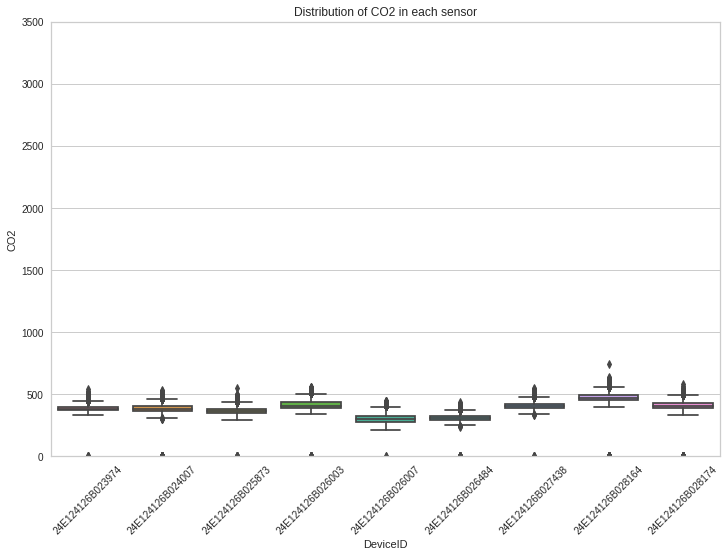

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=dfambientAL, x='DeviceID', y='CO2',orient = 'v')
plt.ylim(0, 3500)
plt.title('Distribution of CO2 in each sensor')
plt.xticks(rotation=45)
plt.show()

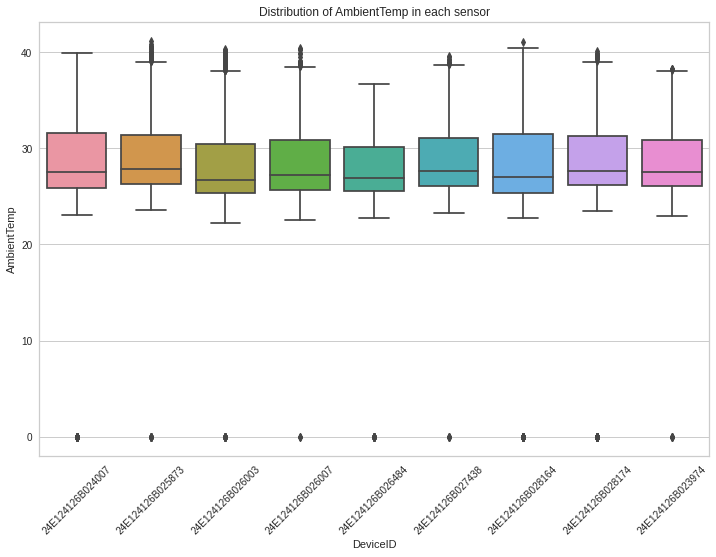

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=dfambientAL, x='DeviceID', y='AmbientTemp',orient = 'v')
plt.title('Distribution of AmbientTemp in each sensor')
plt.xticks(rotation=45)
plt.show()

In [ ]:
dfambient.describe()

,AmbientTemp,CO2,AmbientHumid,AmbientPressure,hour
count,234150.000000,234150.000000,234150.000000,234150.000000,234150.000000
mean,29.725511,743.933594,83.987363,1007.149148,11.504126
std,3.785485,545.755837,13.704335,36.904730,6.925384
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.600000,374.000000,77.500000,1007.100000,5.000000
50%,30.100000,429.000000,88.000000,1008.600000,12.000000
75%,32.500000,1114.000000,94.000000,1010.000000,18.000000
max,41.100000,3399.000000,100.000000,1016.200000,23.000000


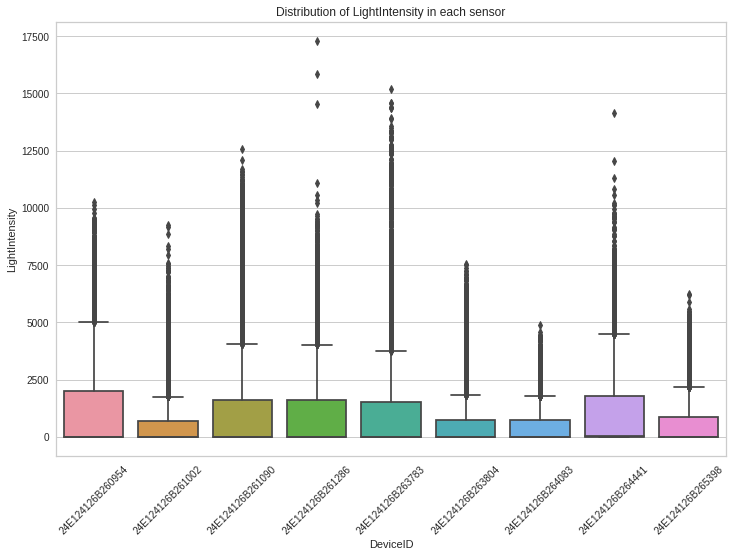

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(data=dflight, x='DeviceID', y='LightIntensity',orient = 'v')
plt.title('Distribution of LightIntensity in each sensor')
plt.xticks(rotation=45)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f95b306f290>,
      dtype=object)

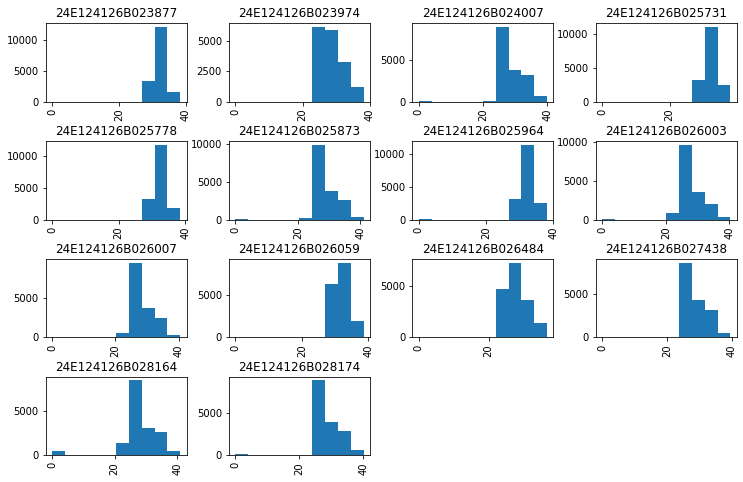

In [ ]:
dfambient.AmbientTemp.hist(by=dfambient.DeviceID,figsize=(12,8))

In [ ]:
dflight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155895 entries, 0 to 155894
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   DeviceID        155895 non-null  object
 1   Datetime        155895 non-null  object
 2   LightIntensity  155895 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.8+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f958eb0c410>,
      dtype=object)

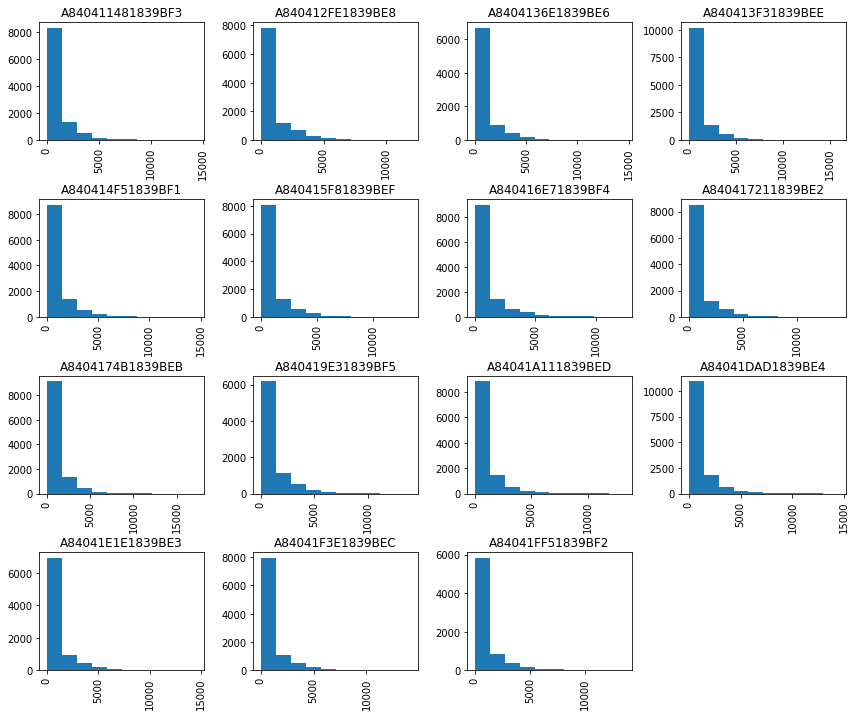

In [ ]:
dflight.LightIntensity.hist(by=dfsoil.DeviceID,figsize=(14,12))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9594cb01d0>,
      dtype=object)

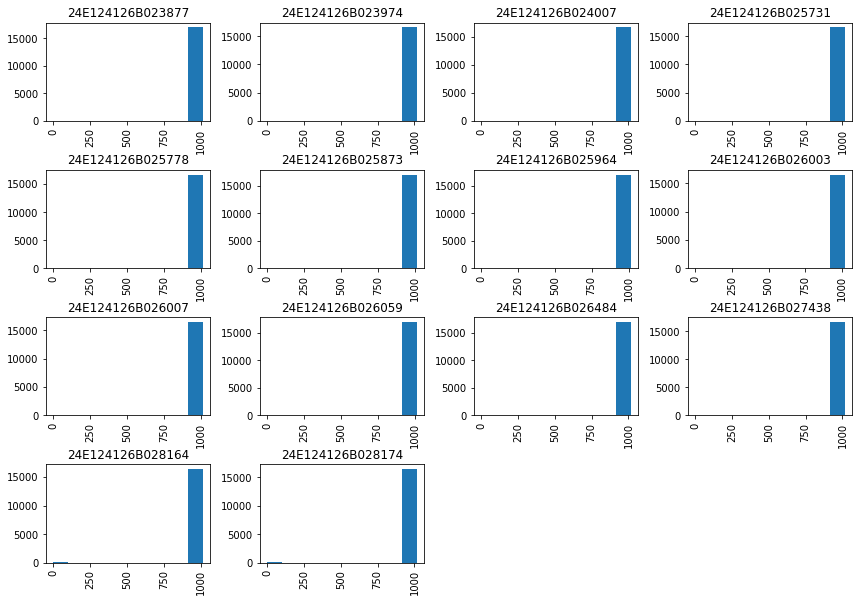

In [ ]:
dfambient.AmbientPressure.hist(by=dfambient.DeviceID,figsize=(14,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2436c95a50>,
      dtype=object)

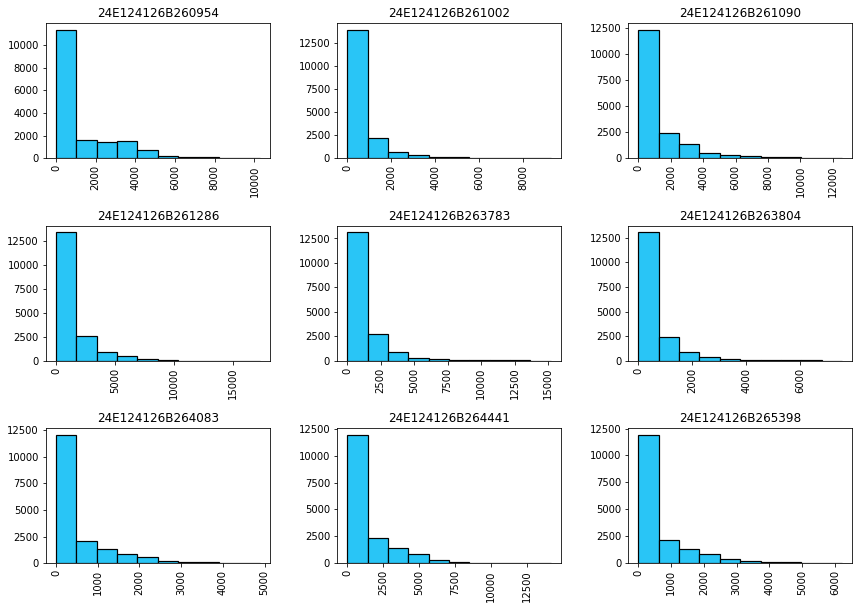

In [ ]:
dflight.LightIntensity.hist(by=dflight.DeviceID,figsize=(14,10),color='#29C5F6',edgecolor='black', linewidth=1.2)

In [ ]:
dfsoil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252875 entries, 0 to 252877
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DeviceID      252875 non-null  object 
 1   Datetime      252875 non-null  object 
 2   SoilEC        252875 non-null  float64
 3   SoilMoisture  252875 non-null  float64
 4   SoilTemp      252875 non-null  float64
dtypes: float64(3), object(2)
memory usage: 11.6+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2434f99810>,
      dtype=object)

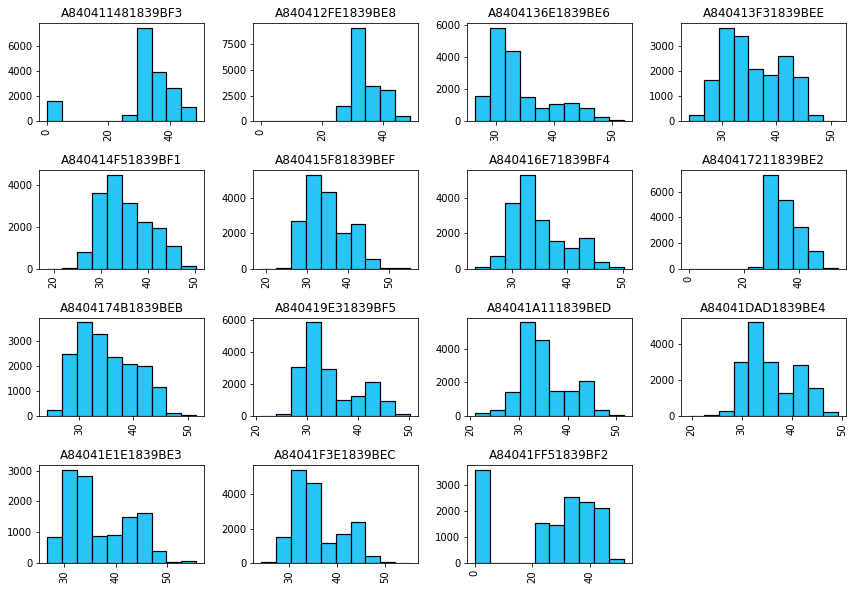

In [ ]:
dfsoil.SoilTemp.hist(by=dfsoil.DeviceID,figsize=(14,10),color='#29C5F6',edgecolor='black', linewidth=1.2)

In [ ]:
plt.figure(figsize=(10,6))

#Histogram for clearfraudscore
bins = [0,100,200,300,400,500,600,700,800,900,1000]
plt.hist(dflight.loc[dfambient['DeviceID'] == '24E124126B026059']['LightIntensity'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,5000])
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('LightIntensity-24E124126B026059')

Text(0.5, 1.0, 'AmbientPressure-24E124126B025778')

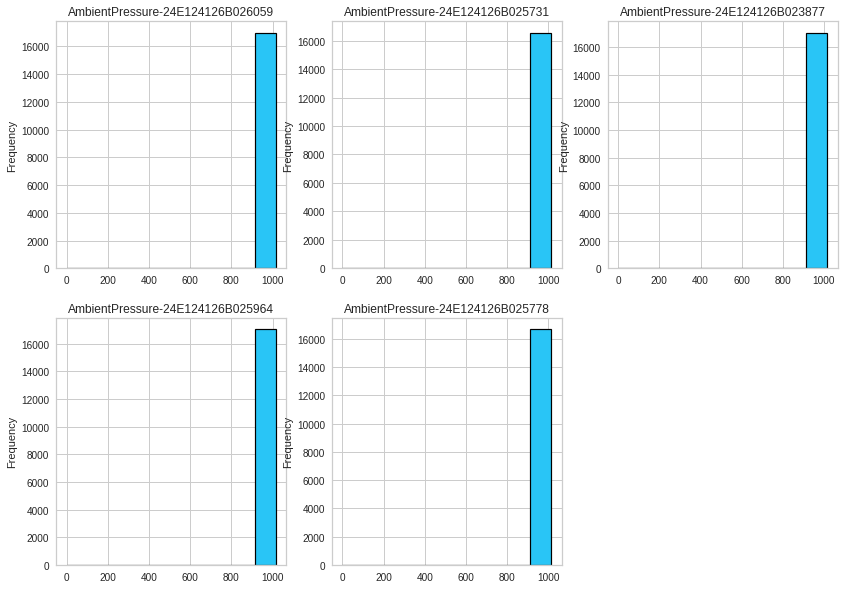

In [ ]:
plt.figure(figsize=(14,10))

#Histogram for loanAmount
plt.subplot(2, 3, 1)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B026059']['AmbientPressure'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,5000])
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientPressure-24E124126B026059')

#Histogram for nPaidOff
plt.subplot(2, 3, 2)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025731']['AmbientPressure'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,21])
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientPressure-24E124126B025731')

plt.subplot(2,3,3)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B023877']['AmbientPressure'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientPressure-24E124126B023877')

plt.subplot(2,3,4)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025964']['AmbientPressure'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientPressure-24E124126B025964')

plt.subplot(2,3,5)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025778']['AmbientPressure'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientPressure-24E124126B025778')

Text(0.5, 1.0, 'AmbientHumid-24E124126B025778')

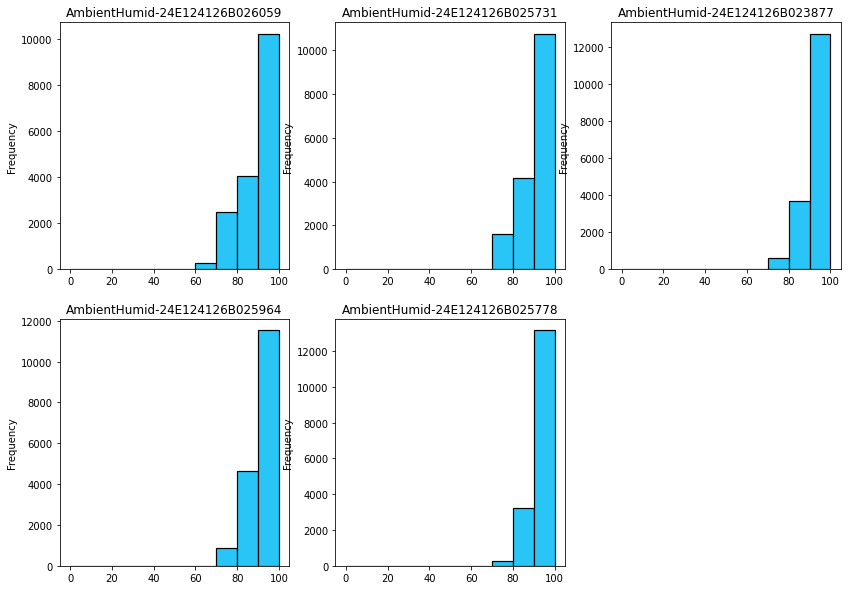

In [ ]:
plt.figure(figsize=(14,10))

#Histogram for loanAmount
plt.subplot(2, 3, 1)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B026059']['AmbientHumid'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,5000])
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientHumid-24E124126B026059')

#Histogram for nPaidOff
plt.subplot(2, 3, 2)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025731']['AmbientHumid'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,21])
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientHumid-24E124126B025731')

plt.subplot(2,3,3)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B023877']['AmbientHumid'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientHumid-24E124126B023877')

plt.subplot(2,3,4)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025964']['AmbientHumid'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientHumid-24E124126B025964')

plt.subplot(2,3,5)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025778']['AmbientHumid'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('AmbientTemp')
plt.ylabel('Frequency')
plt.title('AmbientHumid-24E124126B025778')



Text(0.5, 1.0, 'CO2-24E124126B026484')

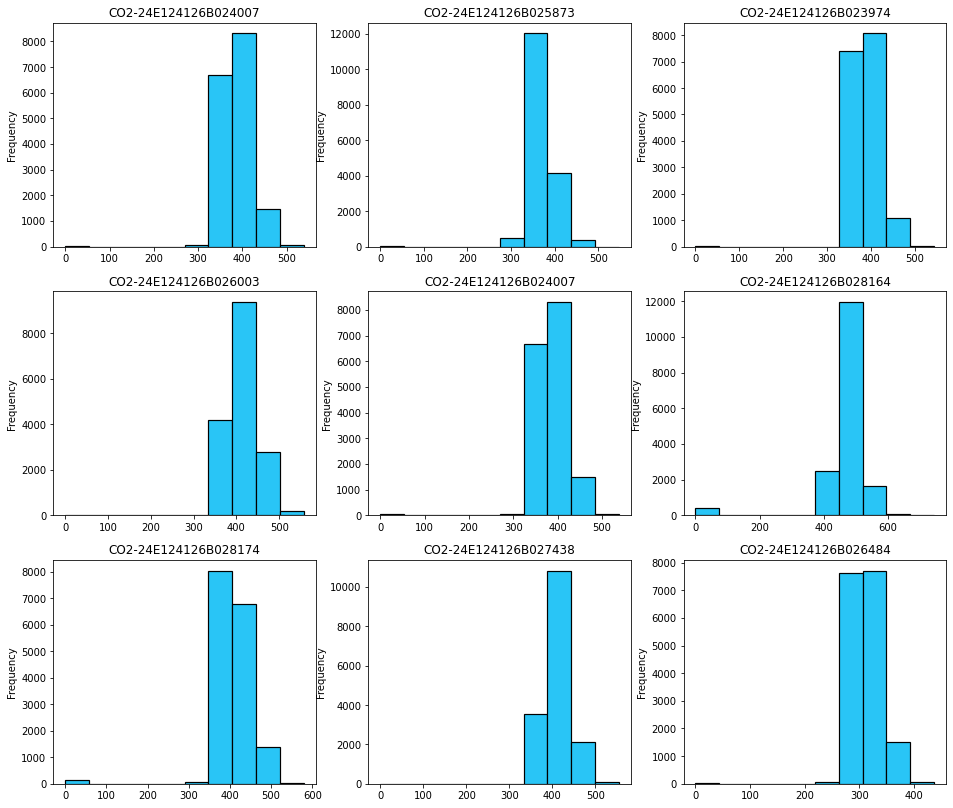

In [ ]:
#AL

plt.figure(figsize=(16,14))

#Histogram for loanAmount
plt.subplot(3,3,1)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B024007']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,5000])
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B024007')

#Histogram for nPaidOff
plt.subplot(3,3,2)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B025873']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlim([0,21])
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B025873')

plt.subplot(3,3,3)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B023974']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B023974')

plt.subplot(3,3,4)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B026003']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B026003')

plt.subplot(3,3,5)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B024007']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B024007')

plt.subplot(3,3,6)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B028164']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B028164')

plt.subplot(3,3,7)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B028174']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B028174')

plt.subplot(3,3,8)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B027438']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B027438')

plt.subplot(3,3,9)
plt.hist(dfambient.loc[dfambient['DeviceID'] == '24E124126B026484']['CO2'],color='#29C5F6',edgecolor='black', linewidth=1.2)
#plt.xlabel('CO2')
plt.ylabel('Frequency')
plt.title('CO2-24E124126B026484')



In [ ]:
df_combined_3.head(10)

,Datetime,AmbientTemp,CO2,AmbientHumid,AmbientPressure,LightIntensity,SoilEC,SoilMoisture,SoilTemp
0,2022-03-02 22:42,0.0,0,0.0,1010.4,NaN,NaN,NaN,NaN
1,2022-03-02 21:49,0.0,0,0.0,0.0,0.0,125.0,11.99,45.25
2,2022-03-02 21:49,0.0,0,0.0,0.0,0.0,125.0,11.99,45.25
3,2022-03-02 21:49,0.0,0,0.0,0.0,0.0,125.0,11.99,45.25
4,2022-03-02 21:50,0.0,0,0.0,0.0,NaN,4649.0,50.47,34.80
5,2022-03-02 22:27,0.0,0,0.0,1010.2,NaN,NaN,NaN,NaN
6,2022-03-02 21:57,0.0,0,0.0,1009.9,NaN,NaN,NaN,NaN
7,2022-03-02 22:12,0.0,0,0.0,1010.0,NaN,NaN,NaN,NaN
8,2022-03-02 21:50,0.0,0,0.0,1009.8,NaN,4649.0,50.47,34.80
9,2022-03-02 22:40,0.0,0,0.0,1010.6,0.0,NaN,NaN,NaN


In [ ]:
df_combined.tail()

,DeviceID_x,Datetime,AmbientTemp,CO2,AmbientHumid,AmbientPressure,DeviceID_y,LightIntensity,DeviceID,SoilEC,SoilMoisture,SoilTemp
600484,NaN,2022-03-08 03:49,NaN,NaN,NaN,NaN,NaN,NaN,A840416E71839BF4,1.0,1.87,33.42
600485,NaN,2022-02-15 19:07,NaN,NaN,NaN,NaN,NaN,NaN,A84041DAD1839BE4,1.0,2.61,35.42
600486,NaN,2022-03-15 00:34,NaN,NaN,NaN,NaN,NaN,NaN,A840416E71839BF4,1.0,2.15,27.96
600487,NaN,2022-05-24 01:26,NaN,NaN,NaN,NaN,NaN,NaN,A840411481839BF3,1.0,7.71,31.96
600488,NaN,2021-12-20 09:24,NaN,NaN,NaN,NaN,NaN,NaN,A84041DAD1839BE4,1.0,0.00,31.96


In [ ]:
df_combinedAL.to_csv('df_combinedAL.csv',index=False)

In [ ]:
df_combinedRT.to_csv('df_combinedRT.csv',index =False)

In [ ]:
 model = LinearRegression()

In [ ]:
df_combinedAL.head()

,DeviceID_x,Datetime,AmbientTemp,CO2,AmbientHumid,AmbientPressure,DeviceID_y,LightIntensity
0,24E124126B023974,2022-03-02 22:40,0.0,0,0.0,1010.6,24E124126B261286,0.0
1,24E124126B023974,2022-03-02 22:40,0.0,0,0.0,1010.6,24E124126B265398,0.0
2,24E124126B023974,2022-03-02 22:04,0.0,0,0.0,1010.0,NaN,NaN
3,24E124126B023974,2022-03-02 22:03,0.0,0,0.0,0.0,24E124126B261002,0.0
4,24E124126B023974,2022-03-02 22:10,0.0,0,0.0,1010.1,24E124126B261286,0.0
